In [1]:
import wave
import json
import librosa
import csv
import numpy as np
from pywt import wavedec
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-01-15 22:20:09.204781: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 22:20:09.243139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 22:20:09.243189: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 22:20:09.243212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 22:20:09.249335: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 22:20:09.250037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import wave
import json

def reset_csv():
  header = 'filename'
  for i in range(1, 41):
      header += f' mfcc{i}'
  for i in range(1, 13):
    header += f' chroma{i}'
  for i in range(1, 61):
    header += f' cqt{i}'
  header += ' label'
  header = header.split()
  file = open('testing.csv', 'w', newline='')
  with file:
      writer = csv.writer(file)
      writer.writerow(header)

In [4]:
def getModelArray(model_name):
  model_path = '../modelh5/'+model_name+'/best_model/'
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(model_path)):
    filenames.sort()
    filenames = filenames[10:] + filenames[:10]
    # cut each 10 array
    filenames = [filenames[i:i + 10] for i in range(0, len(filenames), 10)]
    return filenames[0], filenames[1], filenames[2], filenames[3], filenames[4], filenames[5], filenames[6], filenames[7], filenames[8], filenames[9]

def getPathModel(model_name):
  a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getModelArray(model_name)
  # switch index 2 to 10
  hasil = []
  for i in [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10]:
    a = i[1]
    i.pop(1)
    i.append(a)
    for j in range(len(i)):
      i[j] = '../modelh5/'+model_name + '/best_model/' + i[j]
  return a1, a2, a3, a4, a5, a6, a7, a8, a9, a10

In [5]:
def testingVHD(array, db):
    index_db = 0
    accuracy_all = []
    precision_all = []
    sensitivity_all = []
    specificity_all = []
    f1_score_all = []

    for model_path in array:
        print("=======================================================")
        print("Processing "+ model_path)
        print("=======================================================")
        dataset_path = '../../data/testing_10/'
        reset_csv()

        for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
                # ensure we're processing a genre sub-folder level
                if dirpath is not dataset_path:
                    semantic_label = dirpath.split("/")[-1]
                    for f in filenames:
                        file_path = os.path.join(dirpath, f)
                        to_append = f'{file_path}'
                        # print(file_path)
                        y, sr = librosa.load(file_path, mono=True, duration=3, sr=8000)
                        coeffs = wavedec(y, f'db{db}', level=10)
                        cA,cD10,cD9,cD8,cD7,cD6,cD5,cD4,cD3,cD2, cD1 = coeffs
                        list_cd = [cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8, cD9, cD10]
                        mfcc = librosa.feature.mfcc(y=list_cd[index_db], sr=8000, n_mfcc=40, n_fft=2048, hop_length=512, n_mels=128)
                        rms = librosa.feature.chroma_stft(y=list_cd[index_db], sr=8000)
                        cqt = np.abs(librosa.cqt(y=list_cd[index_db], sr=sr, n_bins=60))
                        combined_features = np.concatenate((mfcc, rms, cqt), axis=0)
                        to_append = f'{file_path}'
                        for e in combined_features:
                            to_append += f' {np.mean(e.T, axis=0)}'
                        to_append += f' {semantic_label}'
                        file = open('testing.csv', 'a', newline='')
                        with file:
                            writer = csv.writer(file)
                            writer.writerow(to_append.split())
        index_db += 1
        data = pd.read_csv('./testing.csv')
        
        lb = LabelEncoder()
        X = np.expand_dims(data.drop(['label', 'filename'], axis=1), axis=2)
        y = np.expand_dims(data.iloc[:, -1], axis=1)


        model = tf.keras.models.load_model(model_path)
        pred = model.predict(X)
        hasil = []
        class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
        # class_labels = ['MVP', 'MS', 'N', 'MR', 'AS']
        for predic in pred:
            cek = np.argmax(predic)
            hasil.append(class_labels[cek])
        # y_p = np.argmax(pred, axis=1)

        cm = confusion_matrix(y, hasil)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AS', 'MR', 'MS', 'MVP', 'N'])
        disp.plot()
        plt.show()

        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        print("Accuracy :" , ACC, 'mean: ', np.mean(ACC))
        print("Precision :" , PPV, 'mean: ', np.mean(PPV))
        print("Sensitivity :" , TPR, 'mean: ', np.mean(TPR))
        print("Specificity :" , TNR, 'mean: ', np.mean(TNR))
        print("f1_score:", 2 * (PPV * TPR) / (PPV + TPR), 'mean: ', np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        accuracy_all.append(np.mean(ACC))
        precision_all.append(np.mean(PPV))
        sensitivity_all.append(np.mean(TPR))
        specificity_all.append(np.mean(TNR))
        f1_score_all.append(np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        print("\n\n")

    print("=======================================================")
    print("Accuracy All :" , accuracy_all)
    print("Precision All :" , precision_all)
    print("Sensitivity All :" , sensitivity_all)
    print("Specificity All :" , specificity_all)
    print("f1_score All :", f1_score_all)
    print("=======================================================")




In [6]:
a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getPathModel("CNN_FT")

Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb1L1.csv_2.h5
4/4 [==============================] - 0s 4ms/step


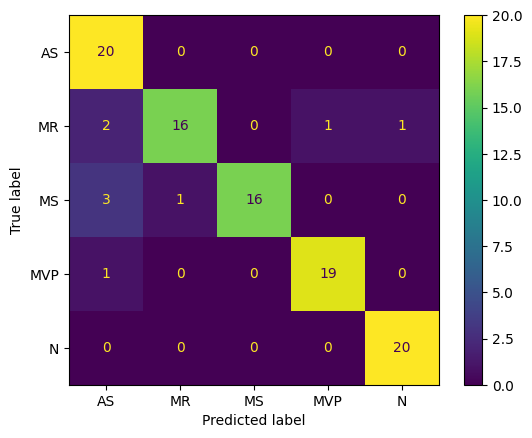

Accuracy : [0.94 0.95 0.96 0.98 0.99] mean:  0.9639999999999999
Precision : [0.76923077 0.94117647 1.         0.95       0.95238095] mean:  0.9225576384399915
Sensitivity : [1.   0.8  0.8  0.95 1.  ] mean:  0.9099999999999999
Specificity : [0.925  0.9875 1.     0.9875 0.9875] mean:  0.9775
f1_score: [0.86956522 0.86486486 0.88888889 0.95       0.97560976] mean:  0.9097857454485239



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb1L2.csv_2.h5
4/4 [==============================] - 0s 2ms/step


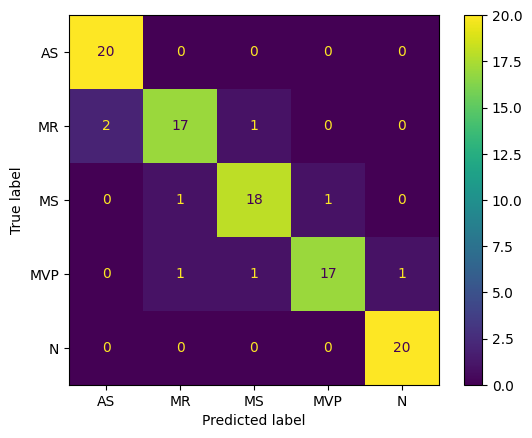

Accuracy : [0.98 0.95 0.96 0.96 0.99] mean:  0.968
Precision : [0.90909091 0.89473684 0.9        0.94444444 0.95238095] mean:  0.9201306296043139
Sensitivity : [1.   0.85 0.9  0.85 1.  ] mean:  0.9199999999999999
Specificity : [0.975  0.975  0.975  0.9875 0.9875] mean:  0.9799999999999999
f1_score: [0.95238095 0.87179487 0.9        0.89473684 0.97560976] mean:  0.9189044844757298



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb1L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


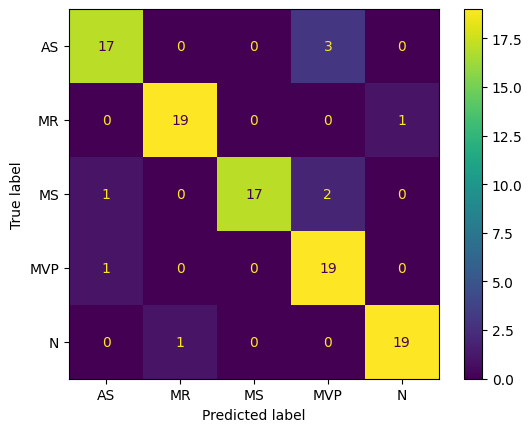

Accuracy : [0.95 0.98 0.97 0.94 0.98] mean:  0.9640000000000001
Precision : [0.89473684 0.95       1.         0.79166667 0.95      ] mean:  0.9172807017543858
Sensitivity : [0.85 0.95 0.85 0.95 0.95] mean:  0.9099999999999999
Specificity : [0.975  0.9875 1.     0.9375 0.9875] mean:  0.9775
f1_score: [0.87179487 0.95       0.91891892 0.86363636 0.95      ] mean:  0.9108700308700308



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb1L4.csv_5.h5
4/4 [==============================] - 0s 3ms/step


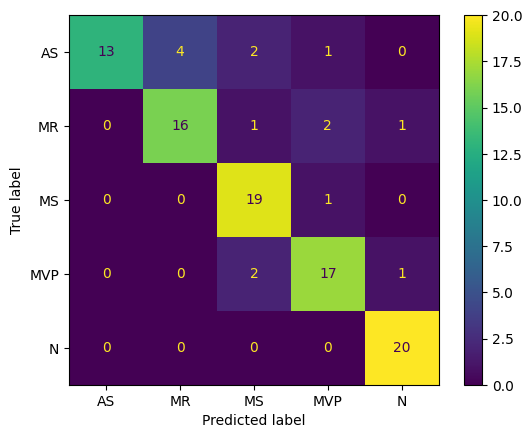

Accuracy : [0.93 0.92 0.94 0.93 0.98] mean:  0.9400000000000001
Precision : [1.         0.8        0.79166667 0.80952381 0.90909091] mean:  0.8620562770562771
Sensitivity : [0.65 0.8  0.95 0.85 1.  ] mean:  0.85
Specificity : [1.     0.95   0.9375 0.95   0.975 ] mean:  0.9625
f1_score: [0.78787879 0.8        0.86363636 0.82926829 0.95238095] mean:  0.8466328793158062



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb1L5.csv_5.h5
4/4 [==============================] - 0s 2ms/step


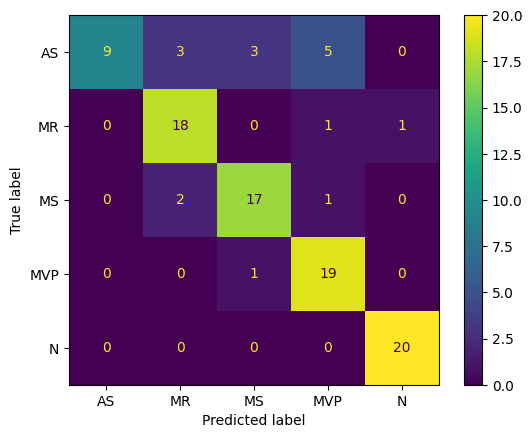

Accuracy : [0.89 0.93 0.93 0.92 0.99] mean:  0.932
Precision : [1.         0.7826087  0.80952381 0.73076923 0.95238095] mean:  0.8550565376652333
Sensitivity : [0.45 0.9  0.85 0.95 1.  ] mean:  0.8300000000000001
Specificity : [1.     0.9375 0.95   0.9125 0.9875] mean:  0.9575000000000001
f1_score: [0.62068966 0.8372093  0.82926829 0.82608696 0.97560976] mean:  0.8177727925600445



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb1L6.csv_3.h5
4/4 [==============================] - 0s 3ms/step


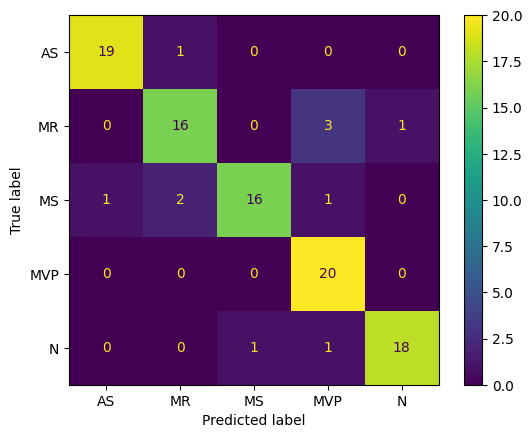

Accuracy : [0.98 0.93 0.95 0.95 0.97] mean:  0.9560000000000001
Precision : [0.95       0.84210526 0.94117647 0.8        0.94736842] mean:  0.8961300309597524
Sensitivity : [0.95 0.8  0.8  1.   0.9 ] mean:  0.89
Specificity : [0.9875 0.9625 0.9875 0.9375 0.9875] mean:  0.9724999999999999
f1_score: [0.95       0.82051282 0.86486486 0.88888889 0.92307692] mean:  0.8894686994686994



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb1L7.csv_2.h5
4/4 [==============================] - 0s 4ms/step


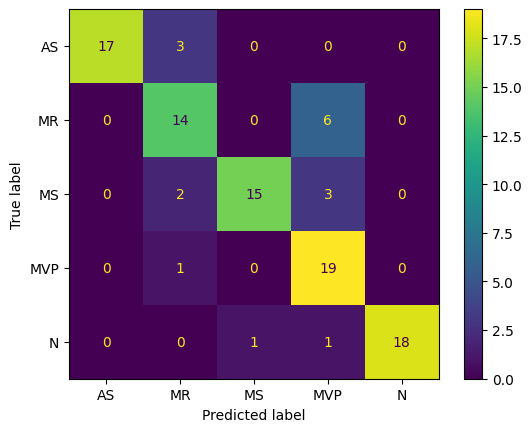

Accuracy : [0.97 0.88 0.94 0.89 0.98] mean:  0.932
Precision : [1.         0.7        0.9375     0.65517241 1.        ] mean:  0.8585344827586207
Sensitivity : [0.85 0.7  0.75 0.95 0.9 ] mean:  0.8300000000000001
Specificity : [1.     0.925  0.9875 0.875  1.    ] mean:  0.9574999999999999
f1_score: [0.91891892 0.7        0.83333333 0.7755102  0.94736842] mean:  0.8350261754773033



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb1L8.csv_2.h5
4/4 [==============================] - 0s 2ms/step


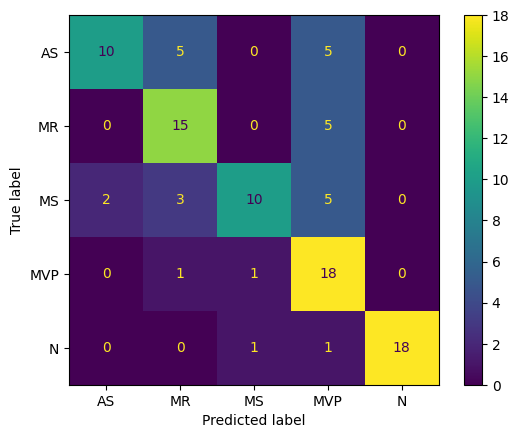

Accuracy : [0.88 0.86 0.88 0.82 0.98] mean:  0.884
Precision : [0.83333333 0.625      0.83333333 0.52941176 1.        ] mean:  0.7642156862745099
Sensitivity : [0.5  0.75 0.5  0.9  0.9 ] mean:  0.71
Specificity : [0.975  0.8875 0.975  0.8    1.    ] mean:  0.9275
f1_score: [0.625      0.68181818 0.625      0.66666667 0.94736842] mean:  0.7091706539074961



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb1L9.csv_5.h5
4/4 [==============================] - 0s 2ms/step


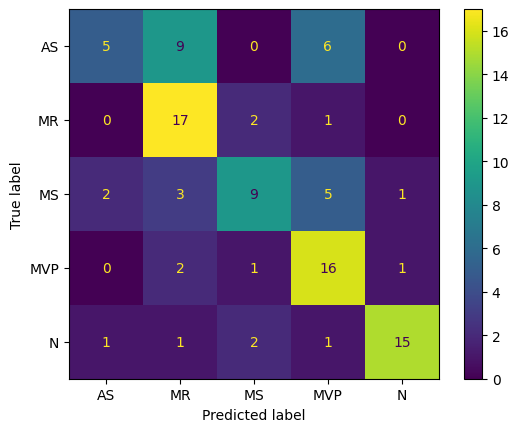

Accuracy : [0.82 0.82 0.84 0.83 0.93] mean:  0.8480000000000001
Precision : [0.625      0.53125    0.64285714 0.55172414 0.88235294] mean:  0.6466368443929296
Sensitivity : [0.25 0.85 0.45 0.8  0.75] mean:  0.62
Specificity : [0.9625 0.8125 0.9375 0.8375 0.975 ] mean:  0.9049999999999999
f1_score: [0.35714286 0.65384615 0.52941176 0.65306122 0.81081081] mean:  0.6008545621990999



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb1L10.csv_5.h5
4/4 [==============================] - 0s 2ms/step


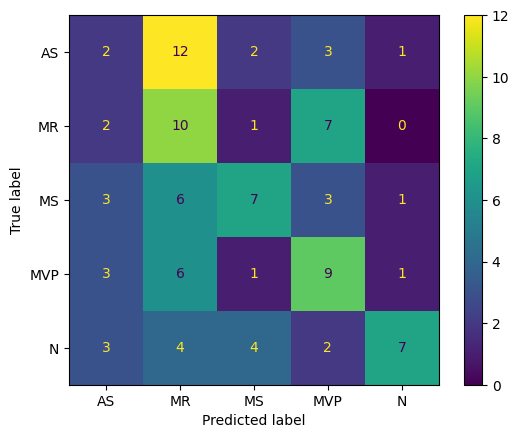

Accuracy : [0.71 0.62 0.79 0.74 0.84] mean:  0.74
Precision : [0.15384615 0.26315789 0.46666667 0.375      0.7       ] mean:  0.3917341430499325
Sensitivity : [0.1  0.5  0.35 0.45 0.35] mean:  0.35
Specificity : [0.8625 0.65   0.9    0.8125 0.9625] mean:  0.8375
f1_score: [0.12121212 0.34482759 0.4        0.40909091 0.46666667] mean:  0.34835945663531875



Accuracy All : [0.9639999999999999, 0.968, 0.9640000000000001, 0.9400000000000001, 0.932, 0.9560000000000001, 0.932, 0.884, 0.8480000000000001, 0.74]
Precision All : [0.9225576384399915, 0.9201306296043139, 0.9172807017543858, 0.8620562770562771, 0.8550565376652333, 0.8961300309597524, 0.8585344827586207, 0.7642156862745099, 0.6466368443929296, 0.3917341430499325]
Sensitivity All : [0.9099999999999999, 0.9199999999999999, 0.9099999999999999, 0.85, 0.8300000000000001, 0.89, 0.8300000000000001, 0.71, 0.62, 0.35]
Specificity All : [0.9775, 0.9799999999999999, 0.9775, 0.9625, 0.9575000000000001, 0.9724999999999999, 0.9574999999999999, 0

In [7]:
testingVHD(a1, 1)

Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb2L1.csv_5.h5


4/4 [==============================] - 0s 3ms/step


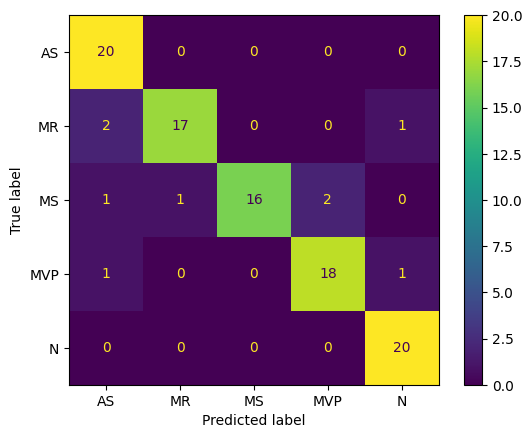

Accuracy : [0.96 0.96 0.96 0.96 0.98] mean:  0.9640000000000001
Precision : [0.83333333 0.94444444 1.         0.9        0.90909091] mean:  0.9173737373737373
Sensitivity : [1.   0.85 0.8  0.9  1.  ] mean:  0.9100000000000001
Specificity : [0.95   0.9875 1.     0.975  0.975 ] mean:  0.9775
f1_score: [0.90909091 0.89473684 0.88888889 0.9        0.95238095] mean:  0.9090195184932026



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb2L2.csv_2.h5
4/4 [==============================] - 0s 2ms/step


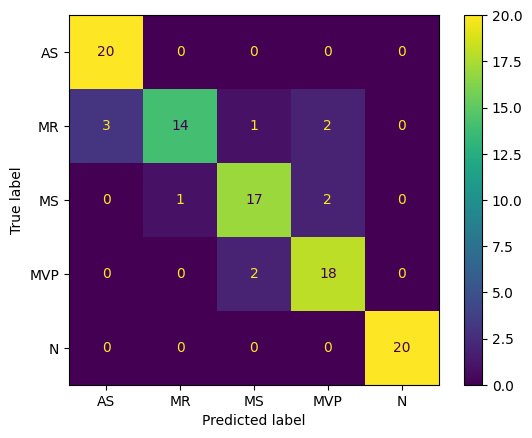

Accuracy : [0.97 0.93 0.94 0.94 1.  ] mean:  0.9559999999999998
Precision : [0.86956522 0.93333333 0.85       0.81818182 1.        ] mean:  0.8942160737812912
Sensitivity : [1.   0.7  0.85 0.9  1.  ] mean:  0.8899999999999999
Specificity : [0.9625 0.9875 0.9625 0.95   1.    ] mean:  0.9724999999999999
f1_score: [0.93023256 0.8        0.85       0.85714286 1.        ] mean:  0.8874750830564786



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb2L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


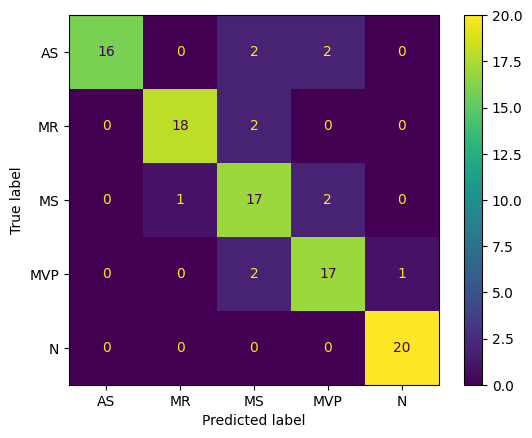

Accuracy : [0.96 0.97 0.91 0.93 0.99] mean:  0.952
Precision : [1.         0.94736842 0.73913043 0.80952381 0.95238095] mean:  0.8896807235480004
Sensitivity : [0.8  0.9  0.85 0.85 1.  ] mean:  0.8800000000000001
Specificity : [1.     0.9875 0.925  0.95   0.9875] mean:  0.97
f1_score: [0.88888889 0.92307692 0.79069767 0.82926829 0.97560976] mean:  0.8815083070329809



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb2L4.csv_5.h5
4/4 [==============================] - 0s 2ms/step


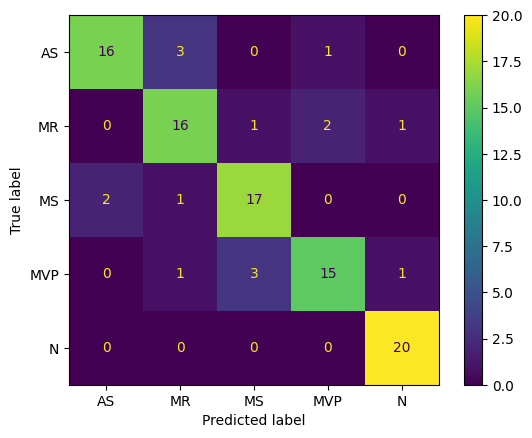

Accuracy : [0.94 0.91 0.93 0.92 0.98] mean:  0.9359999999999999
Precision : [0.88888889 0.76190476 0.80952381 0.83333333 0.90909091] mean:  0.8405483405483405
Sensitivity : [0.8  0.8  0.85 0.75 1.  ] mean:  0.8400000000000001
Specificity : [0.975  0.9375 0.95   0.9625 0.975 ] mean:  0.96
f1_score: [0.84210526 0.7804878  0.82926829 0.78947368 0.95238095] mean:  0.8387431994620698



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb2L5.csv_5.h5
4/4 [==============================] - 0s 2ms/step


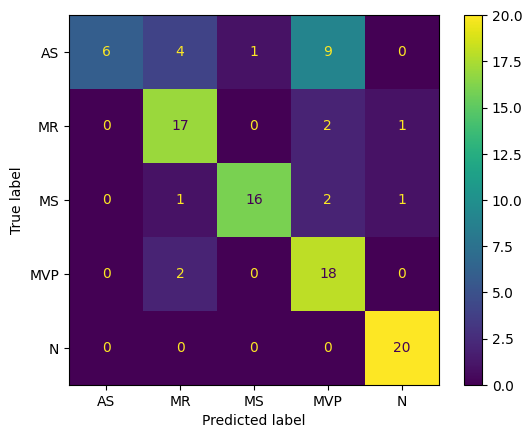

Accuracy : [0.86 0.9  0.95 0.85 0.98] mean:  0.908
Precision : [1.         0.70833333 0.94117647 0.58064516 0.90909091] mean:  0.82784917486056
Sensitivity : [0.3  0.85 0.8  0.9  1.  ] mean:  0.77
Specificity : [1.     0.9125 0.9875 0.8375 0.975 ] mean:  0.9425000000000001
f1_score: [0.46153846 0.77272727 0.86486486 0.70588235 0.95238095] mean:  0.7514787808905457



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb2L6.csv_5.h5
4/4 [==============================] - 0s 3ms/step


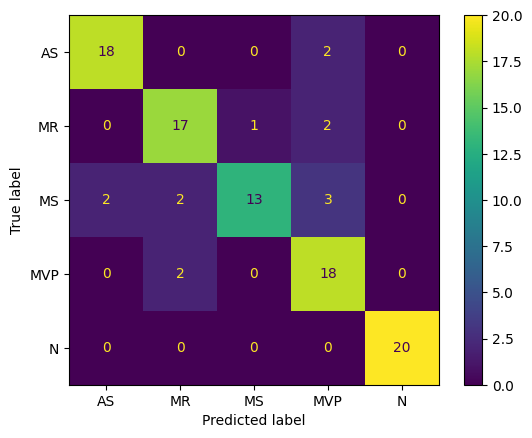

Accuracy : [0.96 0.93 0.92 0.91 1.  ] mean:  0.9440000000000002
Precision : [0.9        0.80952381 0.92857143 0.72       1.        ] mean:  0.8716190476190476
Sensitivity : [0.9  0.85 0.65 0.9  1.  ] mean:  0.86
Specificity : [0.975  0.95   0.9875 0.9125 1.    ] mean:  0.9649999999999999
f1_score: [0.9        0.82926829 0.76470588 0.8        1.        ] mean:  0.8587948350071736



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb2L7.csv_4.h5
4/4 [==============================] - 0s 2ms/step


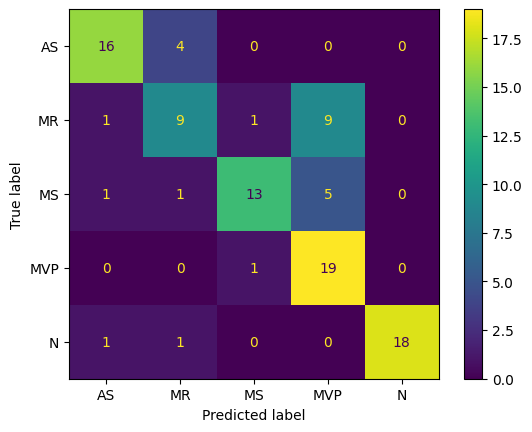

Accuracy : [0.93 0.83 0.91 0.85 0.98] mean:  0.9
Precision : [0.84210526 0.6        0.86666667 0.57575758 1.        ] mean:  0.7769059011164274
Sensitivity : [0.8  0.45 0.65 0.95 0.9 ] mean:  0.7499999999999999
Specificity : [0.9625 0.925  0.975  0.825  1.    ] mean:  0.9375
f1_score: [0.82051282 0.51428571 0.74285714 0.71698113 0.94736842] mean:  0.7484010461567563



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb2L8.csv_2.h5
4/4 [==============================] - 0s 3ms/step


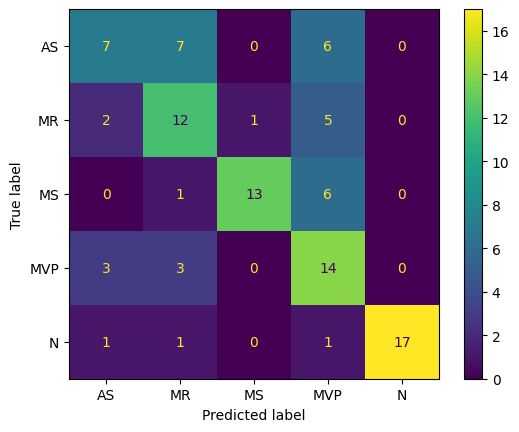

Accuracy : [0.81 0.8  0.92 0.76 0.97] mean:  0.852
Precision : [0.53846154 0.5        0.92857143 0.4375     1.        ] mean:  0.6809065934065934
Sensitivity : [0.35 0.6  0.65 0.7  0.85] mean:  0.63
Specificity : [0.925  0.85   0.9875 0.775  1.    ] mean:  0.9075
f1_score: [0.42424242 0.54545455 0.76470588 0.53846154 0.91891892] mean:  0.6383566618860737



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb2L9.csv_3.h5
4/4 [==============================] - 0s 2ms/step


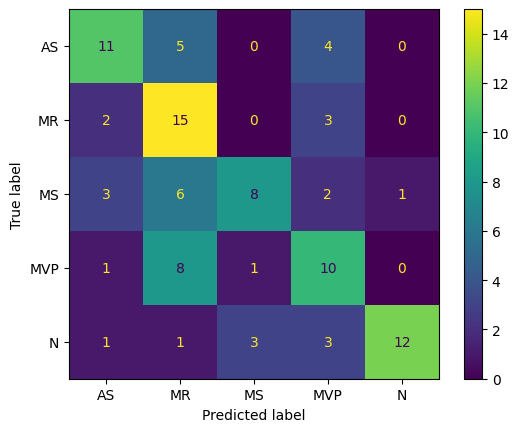

Accuracy : [0.84 0.75 0.84 0.78 0.91] mean:  0.8240000000000001
Precision : [0.61111111 0.42857143 0.66666667 0.45454545 0.92307692] mean:  0.6167943167943168
Sensitivity : [0.55 0.75 0.4  0.5  0.6 ] mean:  0.56
Specificity : [0.9125 0.75   0.95   0.85   0.9875] mean:  0.89
f1_score: [0.57894737 0.54545455 0.5        0.47619048 0.72727273] mean:  0.5655730234677604



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb2L10.csv_5.h5
4/4 [==============================] - 0s 2ms/step


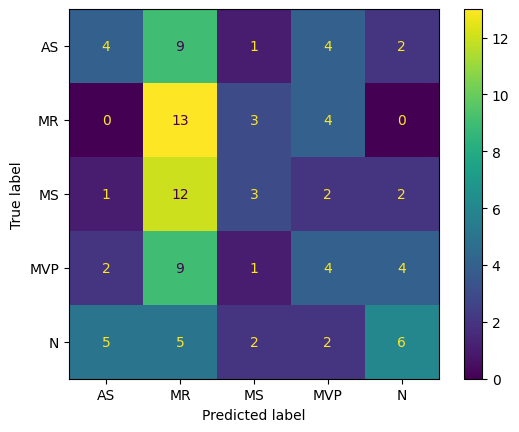

Accuracy : [0.76 0.58 0.76 0.72 0.78] mean:  0.72
Precision : [0.33333333 0.27083333 0.3        0.25       0.42857143] mean:  0.316547619047619
Sensitivity : [0.2  0.65 0.15 0.2  0.3 ] mean:  0.3
Specificity : [0.9    0.5625 0.9125 0.85   0.9   ] mean:  0.825
f1_score: [0.25       0.38235294 0.2        0.22222222 0.35294118] mean:  0.28150326797385616



Accuracy All : [0.9640000000000001, 0.9559999999999998, 0.952, 0.9359999999999999, 0.908, 0.9440000000000002, 0.9, 0.852, 0.8240000000000001, 0.72]
Precision All : [0.9173737373737373, 0.8942160737812912, 0.8896807235480004, 0.8405483405483405, 0.82784917486056, 0.8716190476190476, 0.7769059011164274, 0.6809065934065934, 0.6167943167943168, 0.316547619047619]
Sensitivity All : [0.9100000000000001, 0.8899999999999999, 0.8800000000000001, 0.8400000000000001, 0.77, 0.86, 0.7499999999999999, 0.63, 0.56, 0.3]
Specificity All : [0.9775, 0.9724999999999999, 0.97, 0.96, 0.9425000000000001, 0.9649999999999999, 0.9375, 0.9075, 0.89, 0.825]
f1_sc

In [8]:
testingVHD(a2, 2)

Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb3L1.csv_3.h5


4/4 [==============================] - 0s 2ms/step


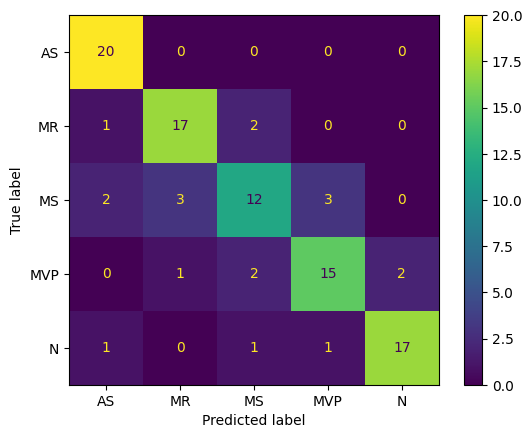

Accuracy : [0.96 0.93 0.87 0.91 0.95] mean:  0.924
Precision : [0.83333333 0.80952381 0.70588235 0.78947368 0.89473684] mean:  0.8065900044228217
Sensitivity : [1.   0.85 0.6  0.75 0.85] mean:  0.8099999999999999
Specificity : [0.95   0.95   0.9375 0.95   0.975 ] mean:  0.9524999999999999
f1_score: [0.90909091 0.82926829 0.64864865 0.76923077 0.87179487] mean:  0.8056066982896251



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb3L2.csv_2.h5
4/4 [==============================] - 0s 2ms/step


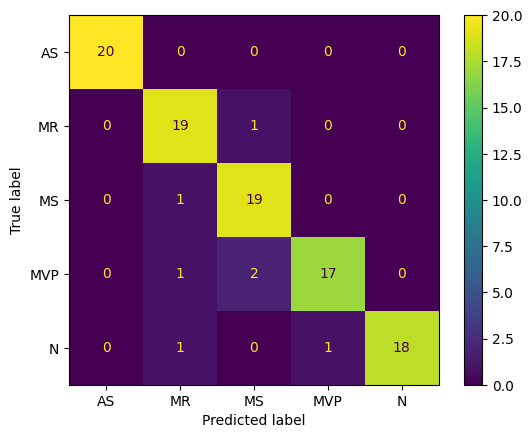

Accuracy : [1.   0.96 0.96 0.96 0.98] mean:  0.9719999999999999
Precision : [1.         0.86363636 0.86363636 0.94444444 1.        ] mean:  0.9343434343434345
Sensitivity : [1.   0.95 0.95 0.85 0.9 ] mean:  0.93
Specificity : [1.     0.9625 0.9625 0.9875 1.    ] mean:  0.9824999999999999
f1_score: [1.         0.9047619  0.9047619  0.89473684 0.94736842] mean:  0.9303258145363408



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb3L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


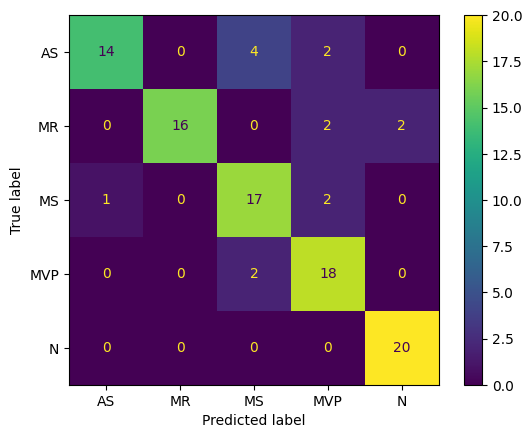

Accuracy : [0.93 0.96 0.91 0.92 0.98] mean:  0.9400000000000001
Precision : [0.93333333 1.         0.73913043 0.75       0.90909091] mean:  0.8663109354413703
Sensitivity : [0.7  0.8  0.85 0.9  1.  ] mean:  0.85
Specificity : [0.9875 1.     0.925  0.925  0.975 ] mean:  0.9625
f1_score: [0.8        0.88888889 0.79069767 0.81818182 0.95238095] mean:  0.8500298667740529



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb3L4.csv_5.h5
4/4 [==============================] - 0s 2ms/step


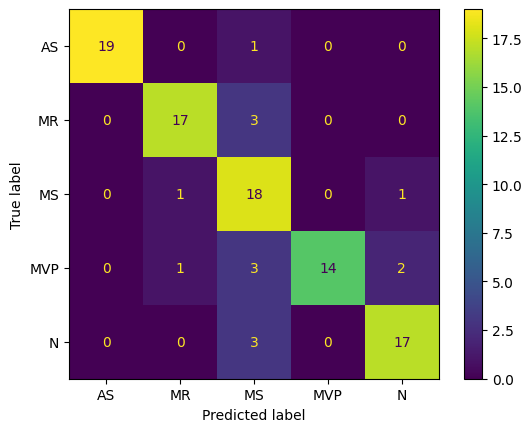

Accuracy : [0.99 0.95 0.88 0.94 0.94] mean:  0.9399999999999998
Precision : [1.         0.89473684 0.64285714 1.         0.85      ] mean:  0.8775187969924811
Sensitivity : [0.95 0.85 0.9  0.7  0.85] mean:  0.8499999999999999
Specificity : [1.     0.975  0.875  1.     0.9625] mean:  0.9625
f1_score: [0.97435897 0.87179487 0.75       0.82352941 0.85      ] mean:  0.8539366515837103



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb3L5.csv_2.h5
4/4 [==============================] - 0s 2ms/step


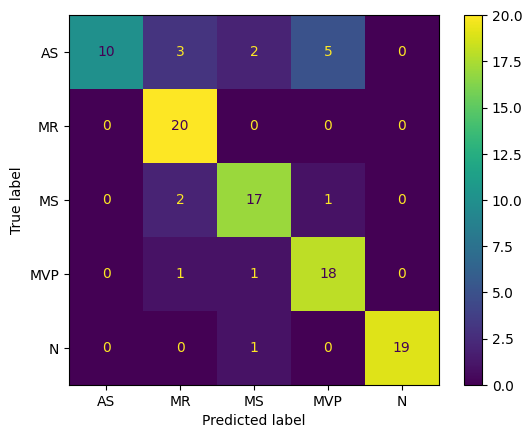

Accuracy : [0.9  0.94 0.93 0.92 0.99] mean:  0.9359999999999999
Precision : [1.         0.76923077 0.80952381 0.75       1.        ] mean:  0.8657509157509157
Sensitivity : [0.5  1.   0.85 0.9  0.95] mean:  0.8400000000000001
Specificity : [1.    0.925 0.95  0.925 1.   ] mean:  0.96
f1_score: [0.66666667 0.86956522 0.82926829 0.81818182 0.97435897] mean:  0.8316081938563382



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb3L6.csv_3.h5
4/4 [==============================] - 0s 2ms/step


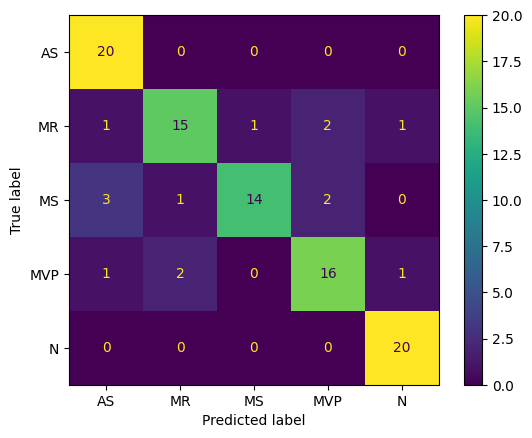

Accuracy : [0.95 0.92 0.93 0.92 0.98] mean:  0.9400000000000001
Precision : [0.8        0.83333333 0.93333333 0.8        0.90909091] mean:  0.8551515151515151
Sensitivity : [1.   0.75 0.7  0.8  1.  ] mean:  0.85
Specificity : [0.9375 0.9625 0.9875 0.95   0.975 ] mean:  0.9625
f1_score: [0.88888889 0.78947368 0.8        0.8        0.95238095] mean:  0.8461487050960737



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb3L7.csv_2.h5
4/4 [==============================] - 0s 2ms/step


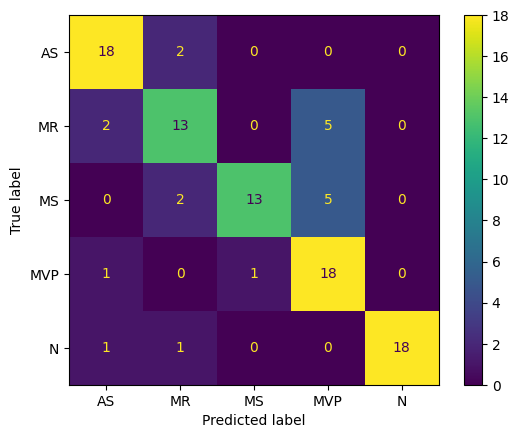

Accuracy : [0.94 0.88 0.92 0.88 0.98] mean:  0.9199999999999999
Precision : [0.81818182 0.72222222 0.92857143 0.64285714 1.        ] mean:  0.8223665223665224
Sensitivity : [0.9  0.65 0.65 0.9  0.9 ] mean:  0.8
Specificity : [0.95   0.9375 0.9875 0.875  1.    ] mean:  0.95
f1_score: [0.85714286 0.68421053 0.76470588 0.75       0.94736842] mean:  0.8006855373728439



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb3L8.csv_3.h5
4/4 [==============================] - 0s 2ms/step


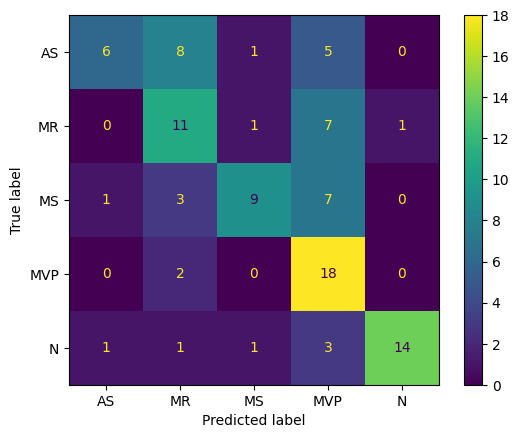

Accuracy : [0.84 0.77 0.86 0.76 0.93] mean:  0.8319999999999999
Precision : [0.75       0.44       0.75       0.45       0.93333333] mean:  0.6646666666666666
Sensitivity : [0.3  0.55 0.45 0.9  0.7 ] mean:  0.5800000000000001
Specificity : [0.975  0.825  0.9625 0.725  0.9875] mean:  0.8949999999999999
f1_score: [0.42857143 0.48888889 0.5625     0.6        0.8       ] mean:  0.5759920634920634



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb3L9.csv_3.h5
4/4 [==============================] - 0s 2ms/step


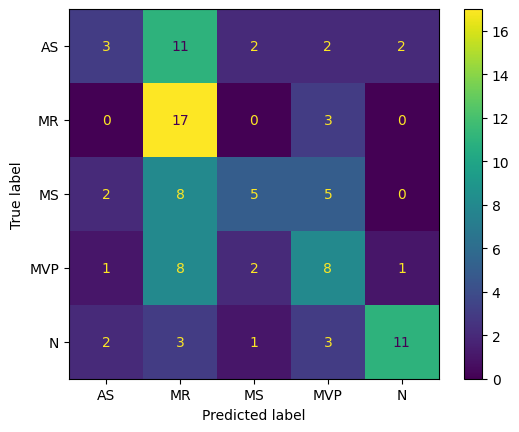

Accuracy : [0.78 0.67 0.8  0.75 0.88] mean:  0.776
Precision : [0.375      0.36170213 0.5        0.38095238 0.78571429] mean:  0.4806737588652482
Sensitivity : [0.15 0.85 0.25 0.4  0.55] mean:  0.44000000000000006
Specificity : [0.9375 0.625  0.9375 0.8375 0.9625] mean:  0.86
f1_score: [0.21428571 0.50746269 0.33333333 0.3902439  0.64705882] mean:  0.4184768920309295



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb3L10.csv_2.h5
4/4 [==============================] - 0s 2ms/step


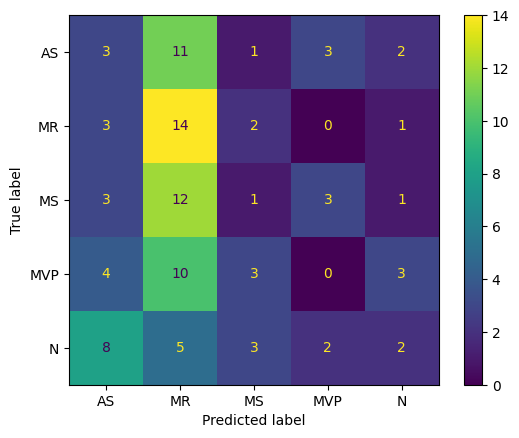

Accuracy : [0.65 0.56 0.72 0.72 0.75] mean:  0.6799999999999999
Precision : [0.14285714 0.26923077 0.1        0.         0.22222222] mean:  0.14686202686202685
Sensitivity : [0.15 0.7  0.05 0.   0.1 ] mean:  0.2
Specificity : [0.775  0.525  0.8875 0.9    0.9125] mean:  0.8
f1_score: [0.14634146 0.38888889 0.06666667        nan 0.13793103] mean:  nan



Accuracy All : [0.924, 0.9719999999999999, 0.9400000000000001, 0.9399999999999998, 0.9359999999999999, 0.9400000000000001, 0.9199999999999999, 0.8319999999999999, 0.776, 0.6799999999999999]
Precision All : [0.8065900044228217, 0.9343434343434345, 0.8663109354413703, 0.8775187969924811, 0.8657509157509157, 0.8551515151515151, 0.8223665223665224, 0.6646666666666666, 0.4806737588652482, 0.14686202686202685]
Sensitivity All : [0.8099999999999999, 0.93, 0.85, 0.8499999999999999, 0.8400000000000001, 0.85, 0.8, 0.5800000000000001, 0.44000000000000006, 0.2]
Specificity All : [0.9524999999999999, 0.9824999999999999, 0.9625, 0.9625, 0.96, 0.9625, 

/tmp/ipykernel_23907/3946732742.py:90: RuntimeWarning: invalid value encountered in divide
  print("f1_score:", 2 * (PPV * TPR) / (PPV + TPR), 'mean: ', np.mean(2 * (PPV * TPR) / (PPV + TPR)))
/tmp/ipykernel_23907/3946732742.py:96: RuntimeWarning: invalid value encountered in divide
  f1_score_all.append(np.mean(2 * (PPV * TPR) / (PPV + TPR)))


In [9]:
testingVHD(a3, 3)

Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb4L1.csv_2.h5


4/4 [==============================] - 0s 2ms/step


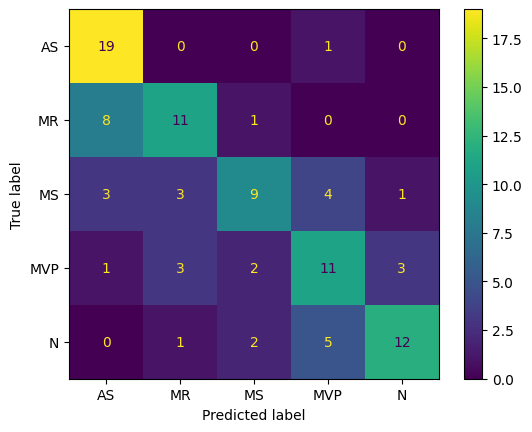

Accuracy : [0.87 0.84 0.84 0.81 0.88] mean:  0.8480000000000001
Precision : [0.61290323 0.61111111 0.64285714 0.52380952 0.75      ] mean:  0.6281362007168458
Sensitivity : [0.95 0.55 0.45 0.55 0.6 ] mean:  0.62
Specificity : [0.85   0.9125 0.9375 0.875  0.95  ] mean:  0.905
f1_score: [0.74509804 0.57894737 0.52941176 0.53658537 0.66666667] mean:  0.6113418409725893



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb4L2.csv_3.h5
4/4 [==============================] - 0s 2ms/step


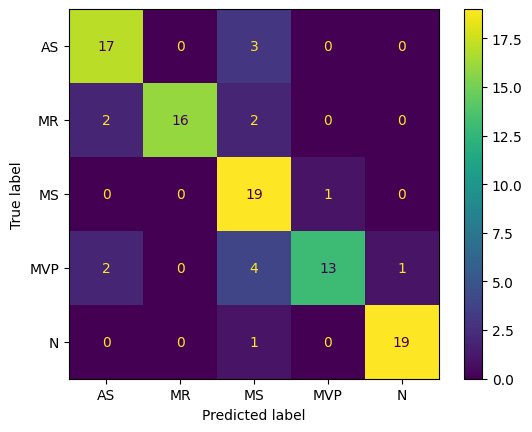

Accuracy : [0.93 0.96 0.89 0.92 0.98] mean:  0.9359999999999999
Precision : [0.80952381 1.         0.65517241 0.92857143 0.95      ] mean:  0.8686535303776683
Sensitivity : [0.85 0.8  0.95 0.65 0.95] mean:  0.8399999999999999
Specificity : [0.95   1.     0.875  0.9875 0.9875] mean:  0.96
f1_score: [0.82926829 0.88888889 0.7755102  0.76470588 0.95      ] mean:  0.8416746536012779



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb4L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


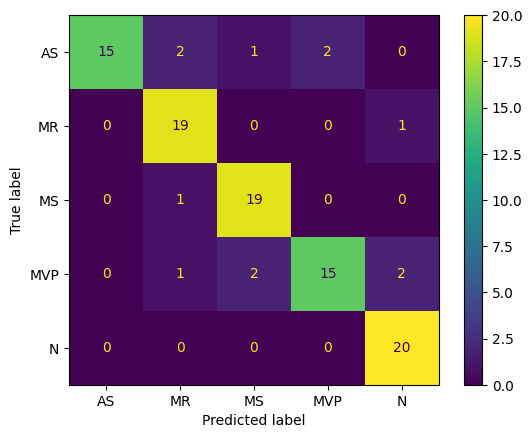

Accuracy : [0.95 0.95 0.96 0.93 0.97] mean:  0.952
Precision : [1.         0.82608696 0.86363636 0.88235294 0.86956522] mean:  0.8883282957451757
Sensitivity : [0.75 0.95 0.95 0.75 1.  ] mean:  0.8800000000000001
Specificity : [1.     0.95   0.9625 0.975  0.9625] mean:  0.9700000000000001
f1_score: [0.85714286 0.88372093 0.9047619  0.81081081 0.93023256] mean:  0.8773338122175331



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb4L4.csv_5.h5
4/4 [==============================] - 0s 2ms/step


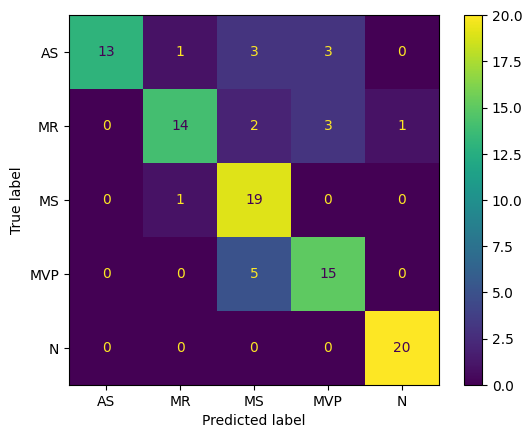

Accuracy : [0.93 0.92 0.89 0.89 0.99] mean:  0.924
Precision : [1.         0.875      0.65517241 0.71428571 0.95238095] mean:  0.839367816091954
Sensitivity : [0.65 0.7  0.95 0.75 1.  ] mean:  0.8099999999999999
Specificity : [1.     0.975  0.875  0.925  0.9875] mean:  0.9525
f1_score: [0.78787879 0.77777778 0.7755102  0.73170732 0.97560976] mean:  0.8096967685817859



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb4L5.csv_3.h5
4/4 [==============================] - 0s 2ms/step


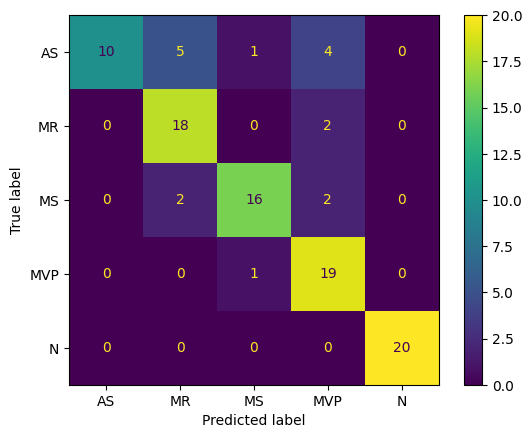

Accuracy : [0.9  0.91 0.94 0.91 1.  ] mean:  0.932
Precision : [1.         0.72       0.88888889 0.7037037  1.        ] mean:  0.8625185185185185
Sensitivity : [0.5  0.9  0.8  0.95 1.  ] mean:  0.8300000000000001
Specificity : [1.     0.9125 0.975  0.9    1.    ] mean:  0.9574999999999999
f1_score: [0.66666667 0.8        0.84210526 0.80851064 1.        ] mean:  0.8234565136244868



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb4L6.csv_2.h5
4/4 [==============================] - 0s 2ms/step


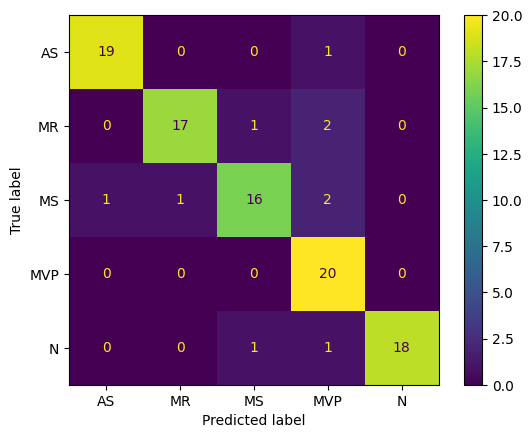

Accuracy : [0.98 0.96 0.94 0.94 0.98] mean:  0.96
Precision : [0.95       0.94444444 0.88888889 0.76923077 1.        ] mean:  0.9105128205128205
Sensitivity : [0.95 0.85 0.8  1.   0.9 ] mean:  0.9
Specificity : [0.9875 0.9875 0.975  0.925  1.    ] mean:  0.975
f1_score: [0.95       0.89473684 0.84210526 0.86956522 0.94736842] mean:  0.9007551487414188



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb4L7.csv_5.h5
4/4 [==============================] - 0s 2ms/step


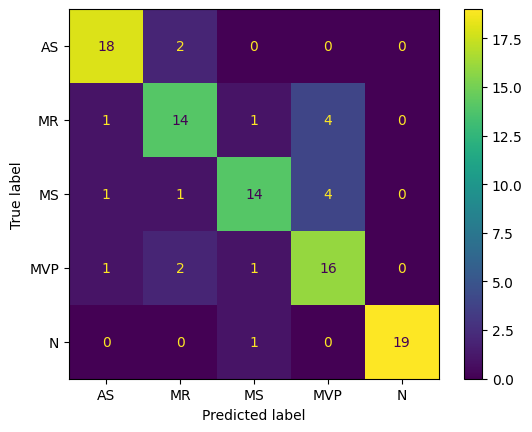

Accuracy : [0.95 0.89 0.91 0.88 0.99] mean:  0.924
Precision : [0.85714286 0.73684211 0.82352941 0.66666667 1.        ] mean:  0.8168362081674776
Sensitivity : [0.9  0.7  0.7  0.8  0.95] mean:  0.8099999999999999
Specificity : [0.9625 0.9375 0.9625 0.9    1.    ] mean:  0.9524999999999999
f1_score: [0.87804878 0.71794872 0.75675676 0.72727273 0.97435897] mean:  0.8108771913649961



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb4L8.csv_2.h5
4/4 [==============================] - 0s 2ms/step


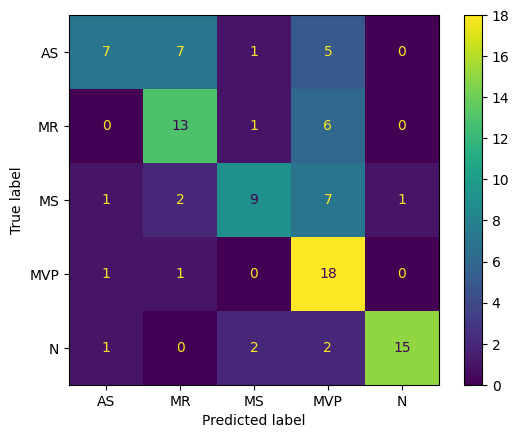

Accuracy : [0.84 0.83 0.85 0.78 0.94] mean:  0.8480000000000001
Precision : [0.7        0.56521739 0.69230769 0.47368421 0.9375    ] mean:  0.6737418588276711
Sensitivity : [0.35 0.65 0.45 0.9  0.75] mean:  0.62
Specificity : [0.9625 0.875  0.95   0.75   0.9875] mean:  0.9049999999999999
f1_score: [0.46666667 0.60465116 0.54545455 0.62068966 0.83333333] mean:  0.6141590726835313



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb4L9.csv_5.h5
4/4 [==============================] - 0s 3ms/step


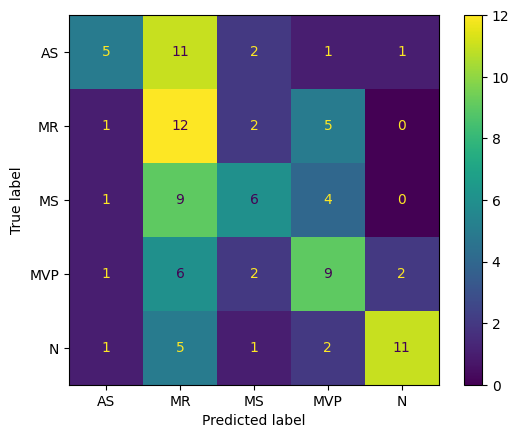

Accuracy : [0.81 0.61 0.79 0.77 0.88] mean:  0.772
Precision : [0.55555556 0.27906977 0.46153846 0.42857143 0.78571429] mean:  0.5020898997643184
Sensitivity : [0.25 0.6  0.3  0.45 0.55] mean:  0.43
Specificity : [0.95   0.6125 0.9125 0.85   0.9625] mean:  0.8575000000000002
f1_score: [0.34482759 0.38095238 0.36363636 0.43902439 0.64705882] mean:  0.43509990891379113



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb4L10.csv_1.h5
4/4 [==============================] - 0s 2ms/step


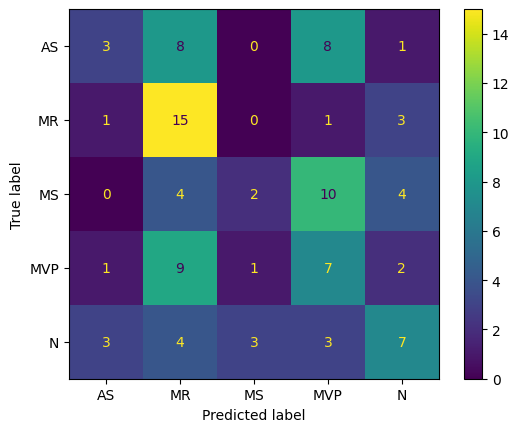

Accuracy : [0.78 0.7  0.78 0.65 0.77] mean:  0.736
Precision : [0.375      0.375      0.33333333 0.24137931 0.41176471] mean:  0.34729546991210275
Sensitivity : [0.15 0.75 0.1  0.35 0.35] mean:  0.34
Specificity : [0.9375 0.6875 0.95   0.725  0.875 ] mean:  0.8350000000000002
f1_score: [0.21428571 0.5        0.15384615 0.28571429 0.37837838] mean:  0.3064449064449064



Accuracy All : [0.8480000000000001, 0.9359999999999999, 0.952, 0.924, 0.932, 0.96, 0.924, 0.8480000000000001, 0.772, 0.736]
Precision All : [0.6281362007168458, 0.8686535303776683, 0.8883282957451757, 0.839367816091954, 0.8625185185185185, 0.9105128205128205, 0.8168362081674776, 0.6737418588276711, 0.5020898997643184, 0.34729546991210275]
Sensitivity All : [0.62, 0.8399999999999999, 0.8800000000000001, 0.8099999999999999, 0.8300000000000001, 0.9, 0.8099999999999999, 0.62, 0.43, 0.34]
Specificity All : [0.905, 0.96, 0.9700000000000001, 0.9525, 0.9574999999999999, 0.975, 0.9524999999999999, 0.9049999999999999, 0.857500000

In [10]:
testingVHD(a4, 4)

Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb5L1.csv_5.h5
4/4 [==============================] - 0s 7ms/step


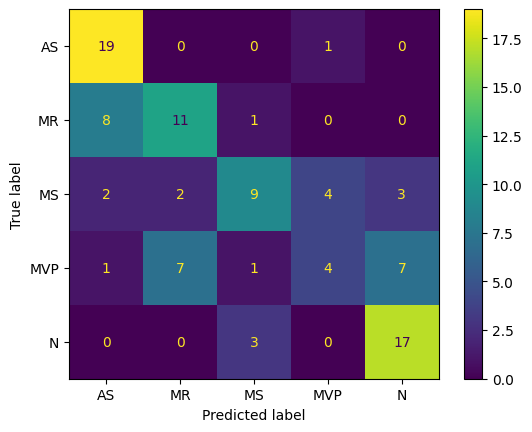

Accuracy : [0.88 0.82 0.84 0.79 0.87] mean:  0.8400000000000001
Precision : [0.63333333 0.55       0.64285714 0.44444444 0.62962963] mean:  0.58005291005291
Sensitivity : [0.95 0.55 0.45 0.2  0.85] mean:  0.6
Specificity : [0.8625 0.8875 0.9375 0.9375 0.875 ] mean:  0.9
f1_score: [0.76       0.55       0.52941176 0.27586207 0.72340426] mean:  0.5677356177981097



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb5L2.csv_3.h5
4/4 [==============================] - 0s 2ms/step


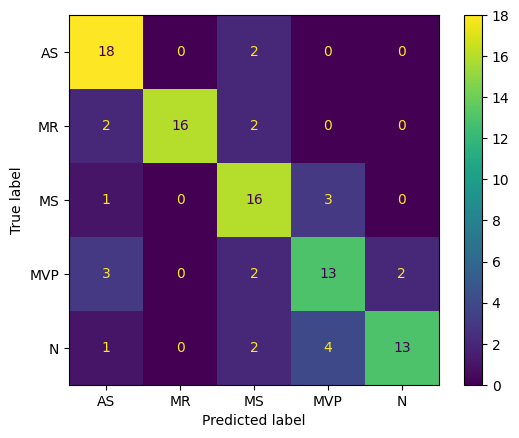

Accuracy : [0.91 0.96 0.88 0.86 0.91] mean:  0.9039999999999999
Precision : [0.72       1.         0.66666667 0.65       0.86666667] mean:  0.7806666666666666
Sensitivity : [0.9  0.8  0.8  0.65 0.65] mean:  0.76
Specificity : [0.9125 1.     0.9    0.9125 0.975 ] mean:  0.9400000000000001
f1_score: [0.8        0.88888889 0.72727273 0.65       0.74285714] mean:  0.7618037518037518



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb5L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


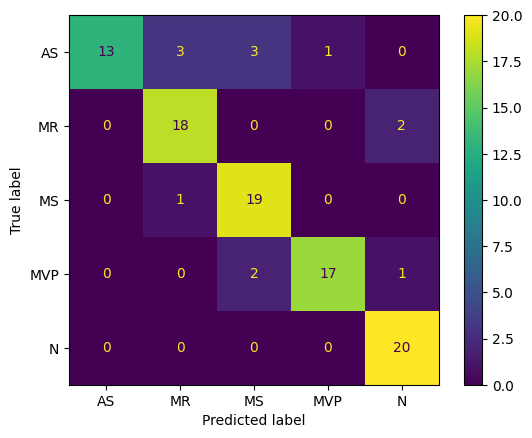

Accuracy : [0.93 0.94 0.94 0.96 0.97] mean:  0.9480000000000001
Precision : [1.         0.81818182 0.79166667 0.94444444 0.86956522] mean:  0.8847716293368467
Sensitivity : [0.65 0.9  0.95 0.85 1.  ] mean:  0.8699999999999999
Specificity : [1.     0.95   0.9375 0.9875 0.9625] mean:  0.9675
f1_score: [0.78787879 0.85714286 0.86363636 0.89473684 0.93023256] mean:  0.8667254817805615



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb5L4.csv_2.h5
4/4 [==============================] - 0s 2ms/step


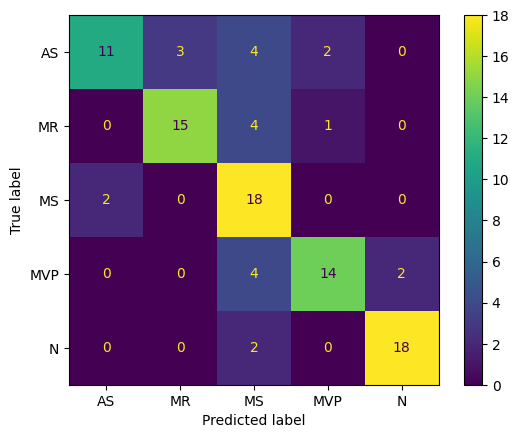

Accuracy : [0.89 0.92 0.84 0.91 0.96] mean:  0.9039999999999999
Precision : [0.84615385 0.83333333 0.5625     0.82352941 0.9       ] mean:  0.793103318250377
Sensitivity : [0.55 0.75 0.9  0.7  0.9 ] mean:  0.76
Specificity : [0.975  0.9625 0.825  0.9625 0.975 ] mean:  0.9400000000000001
f1_score: [0.66666667 0.78947368 0.69230769 0.75675676 0.9       ] mean:  0.7610409599883283



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb5L5.csv_5.h5
4/4 [==============================] - 0s 2ms/step


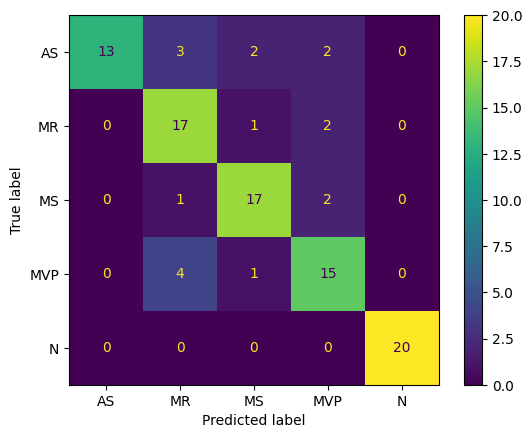

Accuracy : [0.93 0.89 0.93 0.89 1.  ] mean:  0.9280000000000002
Precision : [1.         0.68       0.80952381 0.71428571 1.        ] mean:  0.8407619047619048
Sensitivity : [0.65 0.85 0.85 0.75 1.  ] mean:  0.82
Specificity : [1.    0.9   0.95  0.925 1.   ] mean:  0.9549999999999998
f1_score: [0.78787879 0.75555556 0.82926829 0.73170732 1.        ] mean:  0.8208819906380882



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb5L6.csv_2.h5
4/4 [==============================] - 0s 2ms/step


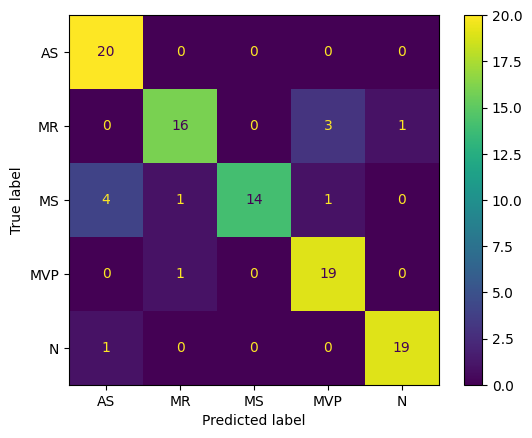

Accuracy : [0.95 0.94 0.94 0.95 0.98] mean:  0.952
Precision : [0.8        0.88888889 1.         0.82608696 0.95      ] mean:  0.8929951690821257
Sensitivity : [1.   0.8  0.7  0.95 0.95] mean:  0.8800000000000001
Specificity : [0.9375 0.975  1.     0.95   0.9875] mean:  0.97
f1_score: [0.88888889 0.84210526 0.82352941 0.88372093 0.95      ] mean:  0.8776488988088096



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb5L7.csv_2.h5
4/4 [==============================] - 0s 2ms/step


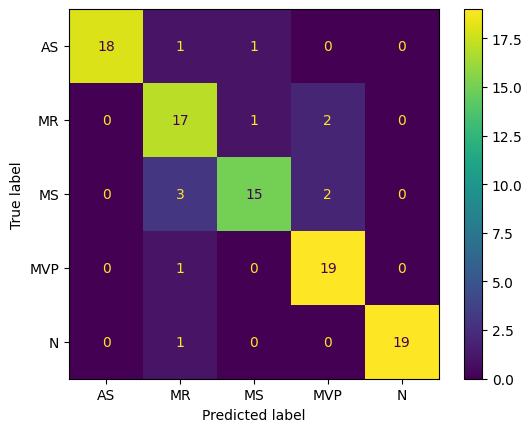

Accuracy : [0.98 0.91 0.93 0.95 0.99] mean:  0.9520000000000002
Precision : [1.         0.73913043 0.88235294 0.82608696 1.        ] mean:  0.8895140664961637
Sensitivity : [0.9  0.85 0.75 0.95 0.95] mean:  0.8800000000000001
Specificity : [1.    0.925 0.975 0.95  1.   ] mean:  0.97
f1_score: [0.94736842 0.79069767 0.81081081 0.88372093 0.97435897] mean:  0.8813913621747158



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb5L8.csv_5.h5
4/4 [==============================] - 0s 2ms/step


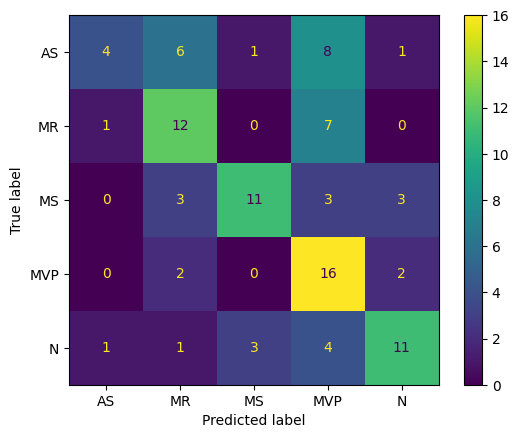

Accuracy : [0.82 0.8  0.87 0.74 0.85] mean:  0.8160000000000001
Precision : [0.66666667 0.5        0.73333333 0.42105263 0.64705882] mean:  0.5936222910216717
Sensitivity : [0.2  0.6  0.55 0.8  0.55] mean:  0.54
Specificity : [0.975 0.85  0.95  0.725 0.925] mean:  0.885
f1_score: [0.30769231 0.54545455 0.62857143 0.55172414 0.59459459] mean:  0.5256074028487822



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb5L9.csv_5.h5
4/4 [==============================] - 0s 2ms/step


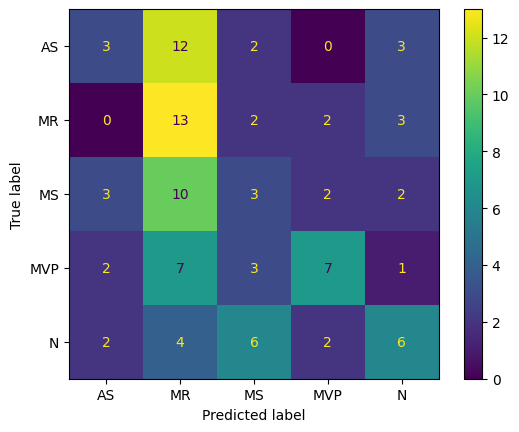

Accuracy : [0.76 0.6  0.7  0.81 0.77] mean:  0.728
Precision : [0.3        0.2826087  0.1875     0.53846154 0.4       ] mean:  0.3417140468227425
Sensitivity : [0.15 0.65 0.15 0.35 0.3 ] mean:  0.32
Specificity : [0.9125 0.5875 0.8375 0.925  0.8875] mean:  0.8300000000000001
f1_score: [0.2        0.39393939 0.16666667 0.42424242 0.34285714] mean:  0.3055411255411255



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb5L10.csv_3.h5
4/4 [==============================] - 0s 2ms/step


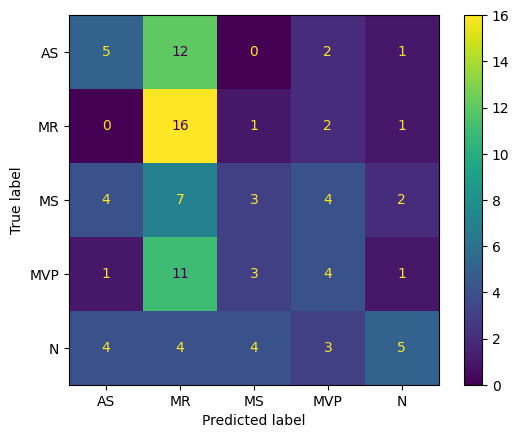

Accuracy : [0.76 0.62 0.75 0.73 0.8 ] mean:  0.732
Precision : [0.35714286 0.32       0.27272727 0.26666667 0.5       ] mean:  0.34330735930735934
Sensitivity : [0.25 0.8  0.15 0.2  0.25] mean:  0.32999999999999996
Specificity : [0.8875 0.575  0.9    0.8625 0.9375] mean:  0.8324999999999999
f1_score: [0.29411765 0.45714286 0.19354839 0.22857143 0.33333333] mean:  0.3013427306406433



Accuracy All : [0.8400000000000001, 0.9039999999999999, 0.9480000000000001, 0.9039999999999999, 0.9280000000000002, 0.952, 0.9520000000000002, 0.8160000000000001, 0.728, 0.732]
Precision All : [0.58005291005291, 0.7806666666666666, 0.8847716293368467, 0.793103318250377, 0.8407619047619048, 0.8929951690821257, 0.8895140664961637, 0.5936222910216717, 0.3417140468227425, 0.34330735930735934]
Sensitivity All : [0.6, 0.76, 0.8699999999999999, 0.76, 0.82, 0.8800000000000001, 0.8800000000000001, 0.54, 0.32, 0.32999999999999996]
Specificity All : [0.9, 0.9400000000000001, 0.9675, 0.9400000000000001, 0.95499999999

In [11]:
testingVHD(a5, 5)

Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb6L1.csv_2.h5
4/4 [==============================] - 0s 2ms/step


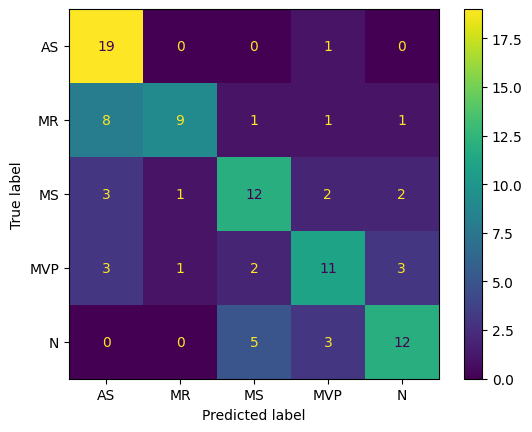

Accuracy : [0.85 0.87 0.84 0.84 0.86] mean:  0.852
Precision : [0.57575758 0.81818182 0.6        0.61111111 0.66666667] mean:  0.6543434343434343
Sensitivity : [0.95 0.45 0.6  0.55 0.6 ] mean:  0.63
Specificity : [0.825  0.975  0.9    0.9125 0.925 ] mean:  0.9075
f1_score: [0.71698113 0.58064516 0.6        0.57894737 0.63157895] mean:  0.6216305218310536



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb6L2.csv_4.h5
4/4 [==============================] - 0s 2ms/step


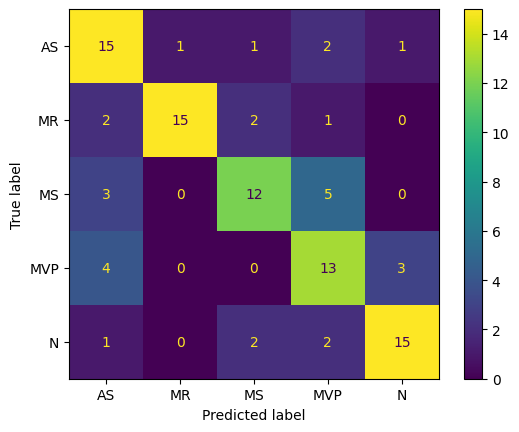

Accuracy : [0.85 0.94 0.87 0.83 0.91] mean:  0.8800000000000001
Precision : [0.6        0.9375     0.70588235 0.56521739 0.78947368] mean:  0.7196146856912101
Sensitivity : [0.75 0.75 0.6  0.65 0.75] mean:  0.7
Specificity : [0.875  0.9875 0.9375 0.875  0.95  ] mean:  0.925
f1_score: [0.66666667 0.83333333 0.64864865 0.60465116 0.76923077] mean:  0.704506116134023



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb6L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


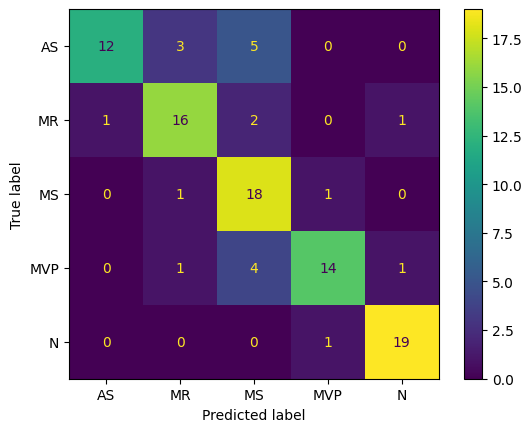

Accuracy : [0.91 0.91 0.87 0.92 0.97] mean:  0.916
Precision : [0.92307692 0.76190476 0.62068966 0.875      0.9047619 ] mean:  0.8170866489832008
Sensitivity : [0.6  0.8  0.9  0.7  0.95] mean:  0.79
Specificity : [0.9875 0.9375 0.8625 0.975  0.975 ] mean:  0.9475
f1_score: [0.72727273 0.7804878  0.73469388 0.77777778 0.92682927] mean:  0.7894122911544514



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb6L4.csv_3.h5
4/4 [==============================] - 0s 2ms/step


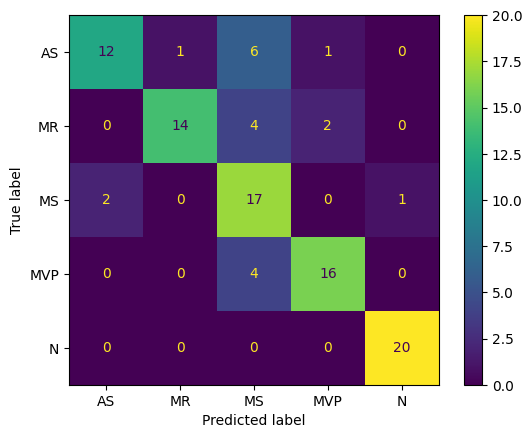

Accuracy : [0.9  0.93 0.83 0.93 0.99] mean:  0.916
Precision : [0.85714286 0.93333333 0.5483871  0.84210526 0.95238095] mean:  0.8266699005578462
Sensitivity : [0.6  0.7  0.85 0.8  1.  ] mean:  0.79
Specificity : [0.975  0.9875 0.825  0.9625 0.9875] mean:  0.9475
f1_score: [0.70588235 0.8        0.66666667 0.82051282 0.97560976] mean:  0.7937343192436449



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb6L5.csv_5.h5
4/4 [==============================] - 0s 2ms/step


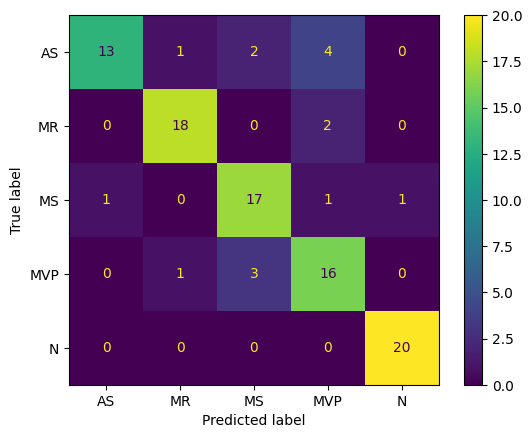

Accuracy : [0.92 0.96 0.92 0.89 0.99] mean:  0.9359999999999999
Precision : [0.92857143 0.9        0.77272727 0.69565217 0.95238095] mean:  0.8498663655185394
Sensitivity : [0.65 0.9  0.85 0.8  1.  ] mean:  0.8400000000000001
Specificity : [0.9875 0.975  0.9375 0.9125 0.9875] mean:  0.96
f1_score: [0.76470588 0.9        0.80952381 0.74418605 0.97560976] mean:  0.838805098897188



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb6L6.csv_2.h5
4/4 [==============================] - 0s 2ms/step


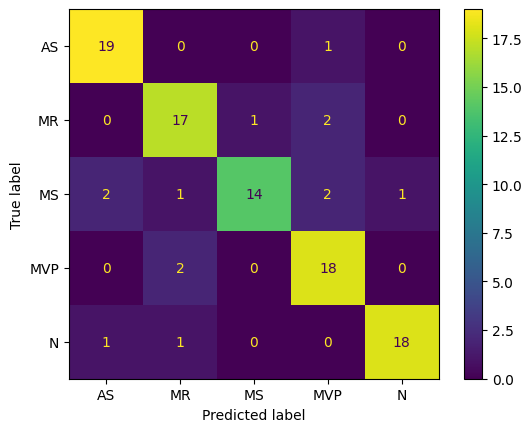

Accuracy : [0.96 0.93 0.93 0.93 0.97] mean:  0.9440000000000002
Precision : [0.86363636 0.80952381 0.93333333 0.7826087  0.94736842] mean:  0.8672941246396624
Sensitivity : [0.95 0.85 0.7  0.9  0.9 ] mean:  0.86
Specificity : [0.9625 0.95   0.9875 0.9375 0.9875] mean:  0.9650000000000001
f1_score: [0.9047619  0.82926829 0.8        0.8372093  0.92307692] mean:  0.8588632845694673



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb6L7.csv_2.h5
4/4 [==============================] - 0s 2ms/step


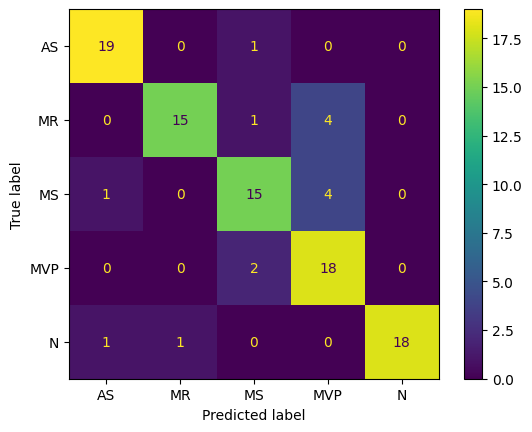

Accuracy : [0.97 0.94 0.91 0.9  0.98] mean:  0.9399999999999998
Precision : [0.9047619  0.9375     0.78947368 0.69230769 1.        ] mean:  0.8648086562560247
Sensitivity : [0.95 0.75 0.75 0.9  0.9 ] mean:  0.85
Specificity : [0.975  0.9875 0.95   0.9    1.    ] mean:  0.9625
f1_score: [0.92682927 0.83333333 0.76923077 0.7826087  0.94736842] mean:  0.8518740975123181



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb6L8.csv_1.h5
4/4 [==============================] - 0s 2ms/step


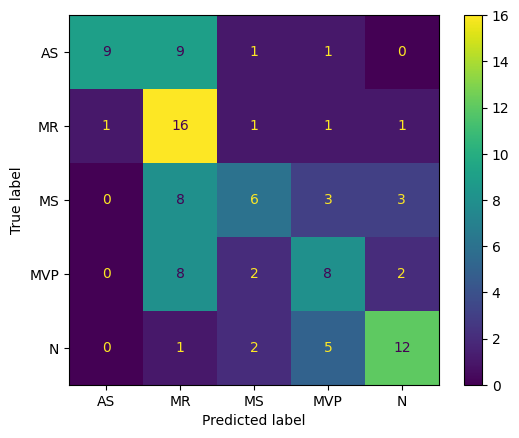

Accuracy : [0.88 0.7  0.8  0.78 0.86] mean:  0.804
Precision : [0.9        0.38095238 0.5        0.44444444 0.66666667] mean:  0.5784126984126984
Sensitivity : [0.45 0.8  0.3  0.4  0.6 ] mean:  0.51
Specificity : [0.9875 0.675  0.925  0.875  0.925 ] mean:  0.8775000000000001
f1_score: [0.6        0.51612903 0.375      0.42105263 0.63157895] mean:  0.5087521222410866



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb6L9.csv_3.h5
4/4 [==============================] - 0s 2ms/step


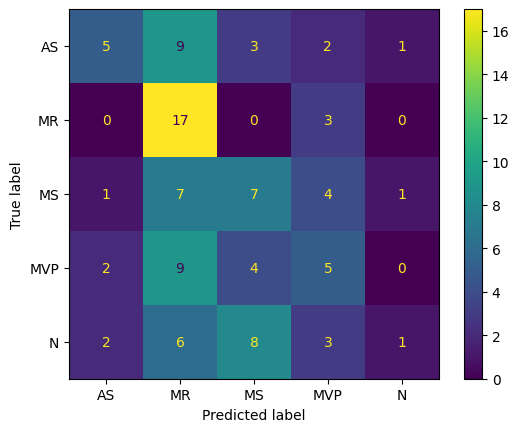

Accuracy : [0.8  0.66 0.72 0.73 0.79] mean:  0.74
Precision : [0.5        0.35416667 0.31818182 0.29411765 0.33333333] mean:  0.35995989304812837
Sensitivity : [0.25 0.85 0.35 0.25 0.05] mean:  0.35000000000000003
Specificity : [0.9375 0.6125 0.8125 0.85   0.975 ] mean:  0.8375
f1_score: [0.33333333 0.5        0.33333333 0.27027027 0.08695652] mean:  0.30477869173521344



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb6L10.csv_2.h5
4/4 [==============================] - 0s 2ms/step


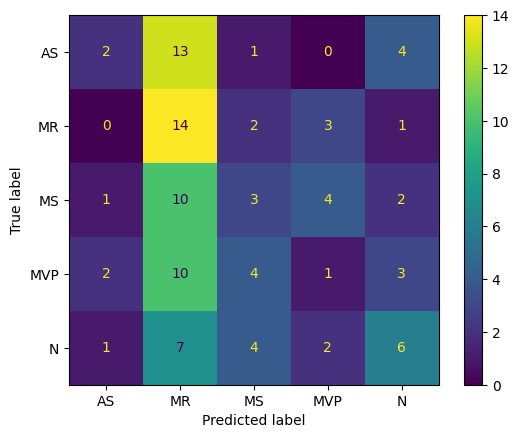

Accuracy : [0.78 0.54 0.72 0.72 0.76] mean:  0.704
Precision : [0.33333333 0.25925926 0.21428571 0.1        0.375     ] mean:  0.25637566137566137
Sensitivity : [0.1  0.7  0.15 0.05 0.3 ] mean:  0.26
Specificity : [0.95   0.5    0.8625 0.8875 0.875 ] mean:  0.8150000000000001
f1_score: [0.15384615 0.37837838 0.17647059 0.06666667 0.33333333] mean:  0.22173902409196522



Accuracy All : [0.852, 0.8800000000000001, 0.916, 0.916, 0.9359999999999999, 0.9440000000000002, 0.9399999999999998, 0.804, 0.74, 0.704]
Precision All : [0.6543434343434343, 0.7196146856912101, 0.8170866489832008, 0.8266699005578462, 0.8498663655185394, 0.8672941246396624, 0.8648086562560247, 0.5784126984126984, 0.35995989304812837, 0.25637566137566137]
Sensitivity All : [0.63, 0.7, 0.79, 0.79, 0.8400000000000001, 0.86, 0.85, 0.51, 0.35000000000000003, 0.26]
Specificity All : [0.9075, 0.925, 0.9475, 0.9475, 0.96, 0.9650000000000001, 0.9625, 0.8775000000000001, 0.8375, 0.8150000000000001]
f1_score All : [0.6216305218310

In [12]:
testingVHD(a6, 6)

Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb7L1.csv_3.h5


4/4 [==============================] - 0s 3ms/step


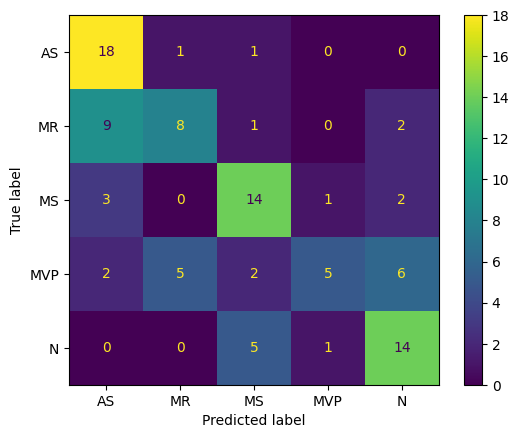

Accuracy : [0.84 0.82 0.85 0.83 0.84] mean:  0.836
Precision : [0.5625     0.57142857 0.60869565 0.71428571 0.58333333] mean:  0.6080486542443064
Sensitivity : [0.9  0.4  0.7  0.25 0.7 ] mean:  0.5900000000000001
Specificity : [0.825  0.925  0.8875 0.975  0.875 ] mean:  0.8975000000000002
f1_score: [0.69230769 0.47058824 0.65116279 0.37037037 0.63636364] mean:  0.5641585450066982



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb7L2.csv_4.h5
4/4 [==============================] - 0s 2ms/step


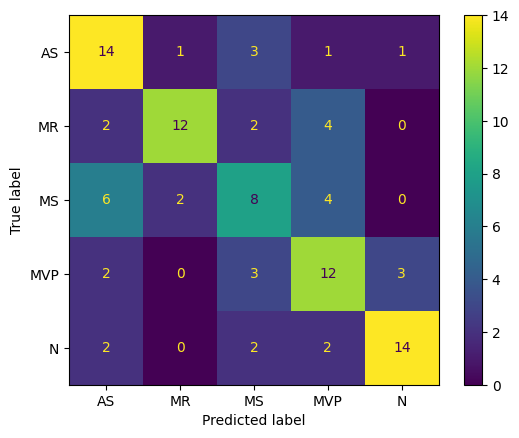

Accuracy : [0.82 0.89 0.78 0.81 0.9 ] mean:  0.8400000000000001
Precision : [0.53846154 0.8        0.44444444 0.52173913 0.77777778] mean:  0.6164845782237086
Sensitivity : [0.7 0.6 0.4 0.6 0.7] mean:  0.6
Specificity : [0.85   0.9625 0.875  0.8625 0.95  ] mean:  0.9
f1_score: [0.60869565 0.68571429 0.42105263 0.55813953 0.73684211] mean:  0.6020888419228049



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb7L3.csv_5.h5
4/4 [==============================] - 0s 2ms/step


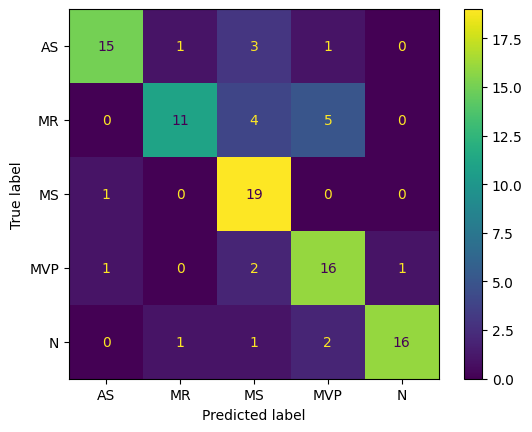

Accuracy : [0.93 0.89 0.89 0.88 0.95] mean:  0.908
Precision : [0.88235294 0.84615385 0.65517241 0.66666667 0.94117647] mean:  0.7983044676756643
Sensitivity : [0.75 0.55 0.95 0.8  0.8 ] mean:  0.7699999999999999
Specificity : [0.975  0.975  0.875  0.9    0.9875] mean:  0.9425000000000001
f1_score: [0.81081081 0.66666667 0.7755102  0.72727273 0.86486486] mean:  0.7690250547393405



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb7L4.csv_2.h5
4/4 [==============================] - 0s 2ms/step


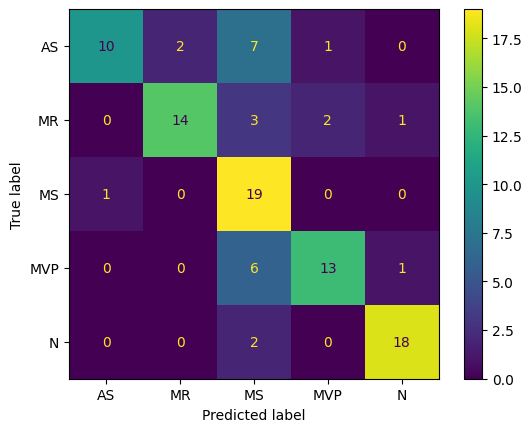

Accuracy : [0.89 0.92 0.81 0.9  0.96] mean:  0.8960000000000001
Precision : [0.90909091 0.875      0.51351351 0.8125     0.9       ] mean:  0.8020208845208845
Sensitivity : [0.5  0.7  0.95 0.65 0.9 ] mean:  0.74
Specificity : [0.9875 0.975  0.775  0.9625 0.975 ] mean:  0.9349999999999999
f1_score: [0.64516129 0.77777778 0.66666667 0.72222222 0.9       ] mean:  0.7423655913978494



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb7L5.csv_2.h5
4/4 [==============================] - 0s 2ms/step


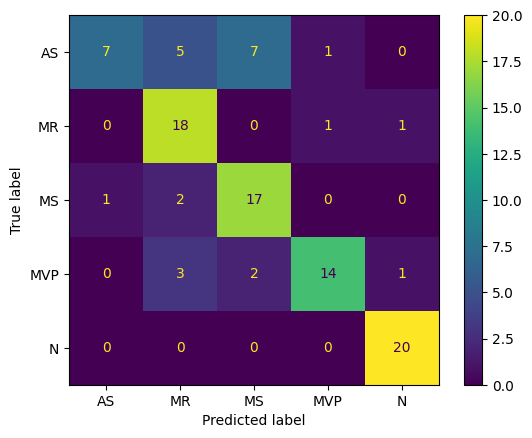

Accuracy : [0.86 0.88 0.88 0.92 0.98] mean:  0.9039999999999999
Precision : [0.875      0.64285714 0.65384615 0.875      0.90909091] mean:  0.7911588411588412
Sensitivity : [0.35 0.9  0.85 0.7  1.  ] mean:  0.76
Specificity : [0.9875 0.875  0.8875 0.975  0.975 ] mean:  0.9400000000000001
f1_score: [0.5        0.75       0.73913043 0.77777778 0.95238095] mean:  0.7438578329882677



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb7L6.csv_2.h5
4/4 [==============================] - 0s 2ms/step


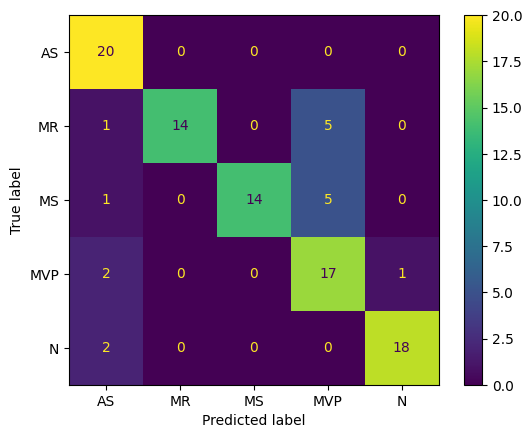

Accuracy : [0.94 0.94 0.94 0.87 0.97] mean:  0.932
Precision : [0.76923077 1.         1.         0.62962963 0.94736842] mean:  0.8692457639826061
Sensitivity : [1.   0.7  0.7  0.85 0.9 ] mean:  0.8300000000000001
Specificity : [0.925  1.     1.     0.875  0.9875] mean:  0.9574999999999999
f1_score: [0.86956522 0.82352941 0.82352941 0.72340426 0.92307692] mean:  0.8326210438633576



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb7L7.csv_5.h5
4/4 [==============================] - 0s 2ms/step


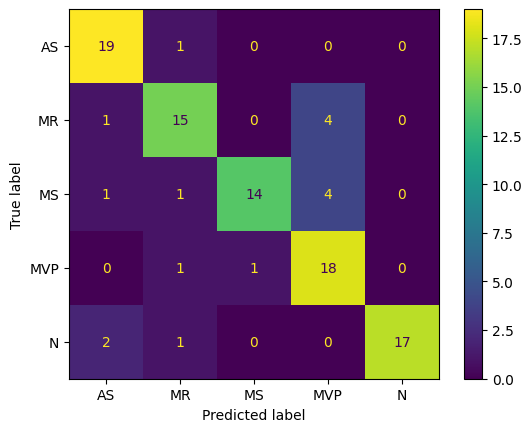

Accuracy : [0.95 0.91 0.93 0.9  0.97] mean:  0.932
Precision : [0.82608696 0.78947368 0.93333333 0.69230769 1.        ] mean:  0.8482403332746582
Sensitivity : [0.95 0.75 0.7  0.9  0.85] mean:  0.8299999999999998
Specificity : [0.95   0.95   0.9875 0.9    1.    ] mean:  0.9574999999999999
f1_score: [0.88372093 0.76923077 0.8        0.7826087  0.91891892] mean:  0.830895862806884



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb7L8.csv_2.h5
4/4 [==============================] - 0s 2ms/step


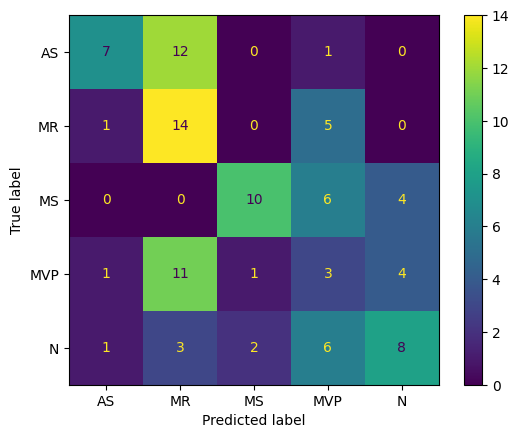

Accuracy : [0.84 0.68 0.87 0.65 0.8 ] mean:  0.768
Precision : [0.7        0.35       0.76923077 0.14285714 0.5       ] mean:  0.4924175824175824
Sensitivity : [0.35 0.7  0.5  0.15 0.4 ] mean:  0.41999999999999993
Specificity : [0.9625 0.675  0.9625 0.775  0.9   ] mean:  0.8550000000000001
f1_score: [0.46666667 0.46666667 0.60606061 0.14634146 0.44444444] mean:  0.4260359694506036



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb7L9.csv_2.h5
4/4 [==============================] - 0s 2ms/step


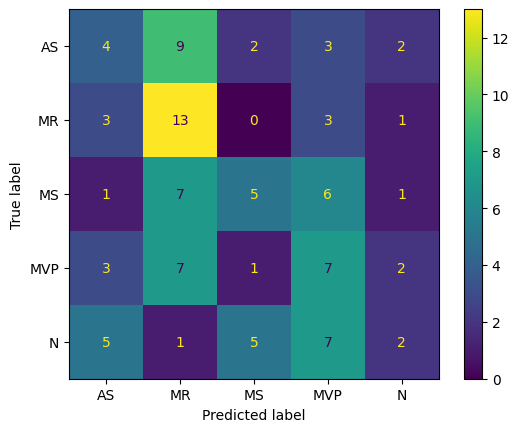

Accuracy : [0.72 0.69 0.77 0.68 0.76] mean:  0.724
Precision : [0.25       0.35135135 0.38461538 0.26923077 0.25      ] mean:  0.301039501039501
Sensitivity : [0.2  0.65 0.25 0.35 0.1 ] mean:  0.31000000000000005
Specificity : [0.85   0.7    0.9    0.7625 0.925 ] mean:  0.8274999999999999
f1_score: [0.22222222 0.45614035 0.3030303  0.30434783 0.14285714] mean:  0.28571956901476353



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb7L10.csv_4.h5
4/4 [==============================] - 0s 2ms/step


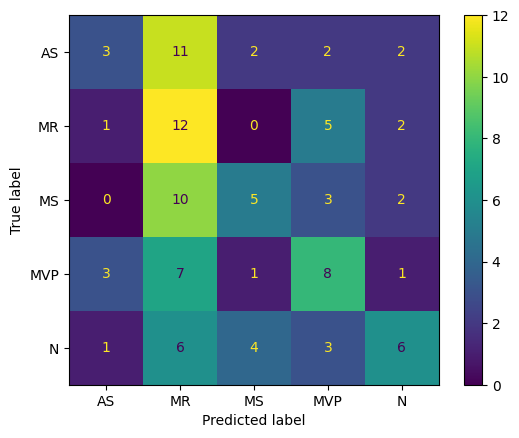

Accuracy : [0.78 0.58 0.78 0.75 0.79] mean:  0.736
Precision : [0.375      0.26086957 0.41666667 0.38095238 0.46153846] mean:  0.37900541487498013
Sensitivity : [0.15 0.6  0.25 0.4  0.3 ] mean:  0.33999999999999997
Specificity : [0.9375 0.575  0.9125 0.8375 0.9125] mean:  0.835
f1_score: [0.21428571 0.36363636 0.3125     0.3902439  0.36363636] mean:  0.32886046879949327



Accuracy All : [0.836, 0.8400000000000001, 0.908, 0.8960000000000001, 0.9039999999999999, 0.932, 0.932, 0.768, 0.724, 0.736]
Precision All : [0.6080486542443064, 0.6164845782237086, 0.7983044676756643, 0.8020208845208845, 0.7911588411588412, 0.8692457639826061, 0.8482403332746582, 0.4924175824175824, 0.301039501039501, 0.37900541487498013]
Sensitivity All : [0.5900000000000001, 0.6, 0.7699999999999999, 0.74, 0.76, 0.8300000000000001, 0.8299999999999998, 0.41999999999999993, 0.31000000000000005, 0.33999999999999997]
Specificity All : [0.8975000000000002, 0.9, 0.9425000000000001, 0.9349999999999999, 0.9400000000000001,

In [13]:
testingVHD(a7, 7)

Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb8L1.csv_3.h5
4/4 [==============================] - 0s 2ms/step


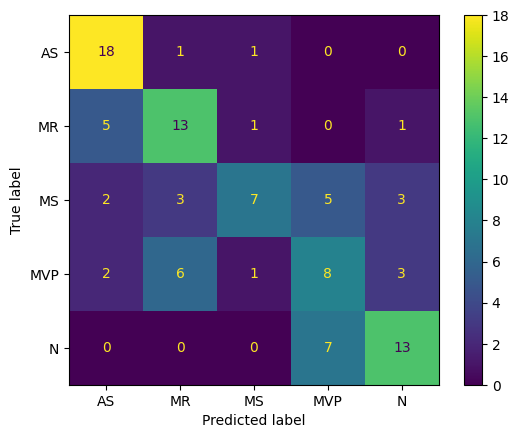

Accuracy : [0.89 0.83 0.84 0.76 0.86] mean:  0.8360000000000001
Precision : [0.66666667 0.56521739 0.7        0.4        0.65      ] mean:  0.5963768115942029
Sensitivity : [0.9  0.65 0.35 0.4  0.65] mean:  0.59
Specificity : [0.8875 0.875  0.9625 0.85   0.9125] mean:  0.8975
f1_score: [0.76595745 0.60465116 0.46666667 0.4        0.65      ] mean:  0.577455055253175



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb8L2.csv_4.h5
4/4 [==============================] - 0s 2ms/step


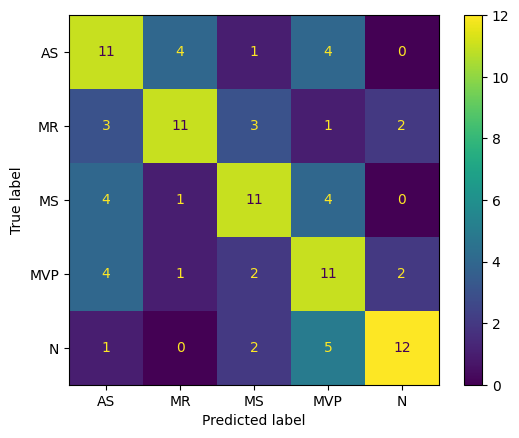

Accuracy : [0.79 0.85 0.83 0.77 0.88] mean:  0.8240000000000001
Precision : [0.47826087 0.64705882 0.57894737 0.44       0.75      ] mean:  0.5788534123031364
Sensitivity : [0.55 0.55 0.55 0.55 0.6 ] mean:  0.56
Specificity : [0.85  0.925 0.9   0.825 0.95 ] mean:  0.89
f1_score: [0.51162791 0.59459459 0.56410256 0.48888889 0.66666667] mean:  0.5651761242458917



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb8L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


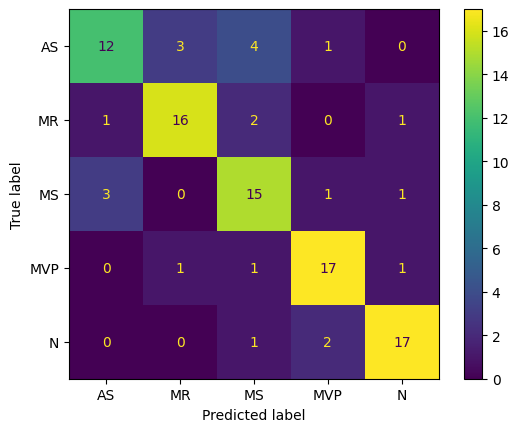

Accuracy : [0.88 0.92 0.87 0.93 0.94] mean:  0.908
Precision : [0.75       0.8        0.65217391 0.80952381 0.85      ] mean:  0.7723395445134575
Sensitivity : [0.6  0.8  0.75 0.85 0.85] mean:  0.77
Specificity : [0.95   0.95   0.9    0.95   0.9625] mean:  0.9425000000000001
f1_score: [0.66666667 0.8        0.69767442 0.82926829 0.85      ] mean:  0.768721875590849



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb8L4.csv_2.h5
4/4 [==============================] - 0s 2ms/step


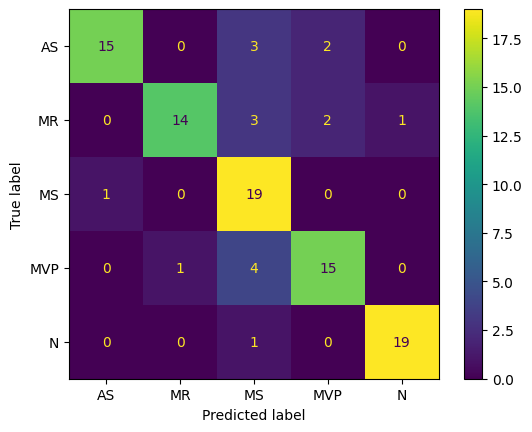

Accuracy : [0.94 0.93 0.88 0.91 0.98] mean:  0.9280000000000002
Precision : [0.9375     0.93333333 0.63333333 0.78947368 0.95      ] mean:  0.8487280701754386
Sensitivity : [0.75 0.7  0.95 0.75 0.95] mean:  0.82
Specificity : [0.9875 0.9875 0.8625 0.95   0.9875] mean:  0.9550000000000001
f1_score: [0.83333333 0.8        0.76       0.76923077 0.95      ] mean:  0.8225128205128204



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb8L5.csv_5.h5
4/4 [==============================] - 0s 2ms/step


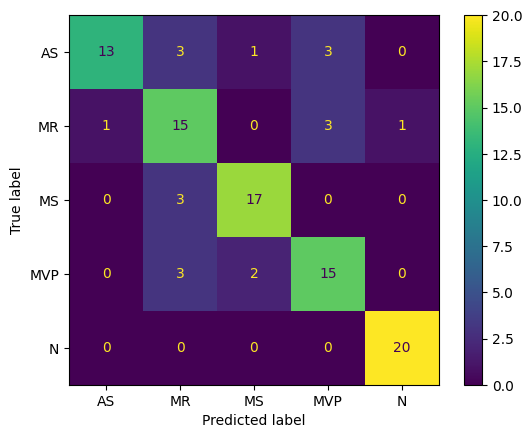

Accuracy : [0.92 0.86 0.94 0.89 0.99] mean:  0.9199999999999999
Precision : [0.92857143 0.625      0.85       0.71428571 0.95238095] mean:  0.8140476190476191
Sensitivity : [0.65 0.75 0.85 0.75 1.  ] mean:  0.8
Specificity : [0.9875 0.8875 0.9625 0.925  0.9875] mean:  0.95
f1_score: [0.76470588 0.68181818 0.85       0.73170732 0.97560976] mean:  0.800768227468371



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb8L6.csv_2.h5
4/4 [==============================] - 0s 2ms/step


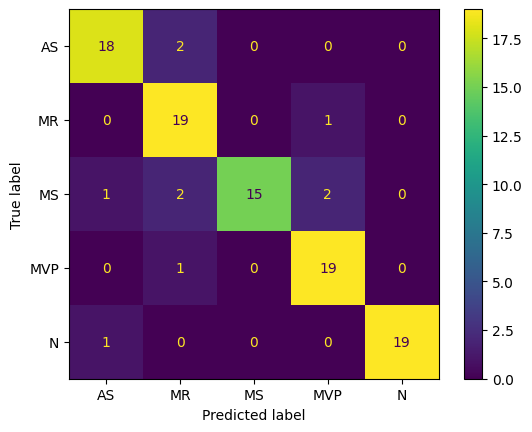

Accuracy : [0.96 0.94 0.95 0.96 0.99] mean:  0.96
Precision : [0.9        0.79166667 1.         0.86363636 1.        ] mean:  0.9110606060606059
Sensitivity : [0.9  0.95 0.75 0.95 0.95] mean:  0.9
Specificity : [0.975  0.9375 1.     0.9625 1.    ] mean:  0.975
f1_score: [0.9        0.86363636 0.85714286 0.9047619  0.97435897] mean:  0.89998001998002



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb8L7.csv_5.h5
4/4 [==============================] - 0s 2ms/step


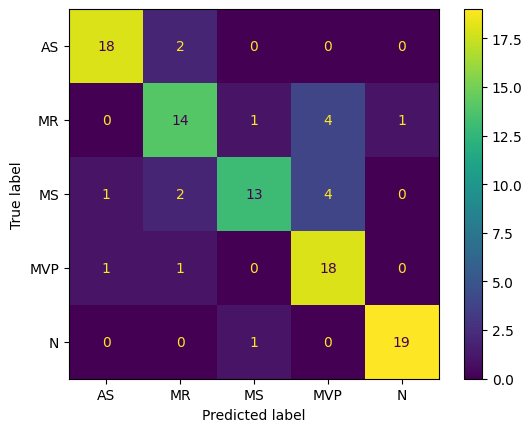

Accuracy : [0.96 0.89 0.91 0.9  0.98] mean:  0.9280000000000002
Precision : [0.9        0.73684211 0.86666667 0.69230769 0.95      ] mean:  0.8291632928475033
Sensitivity : [0.9  0.7  0.65 0.9  0.95] mean:  0.82
Specificity : [0.975  0.9375 0.975  0.9    0.9875] mean:  0.9550000000000001
f1_score: [0.9        0.71794872 0.74285714 0.7826087  0.95      ] mean:  0.8186829112916069



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb8L8.csv_1.h5
4/4 [==============================] - 0s 2ms/step


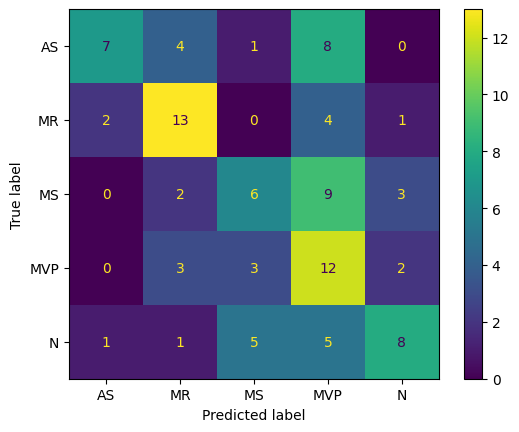

Accuracy : [0.84 0.83 0.77 0.66 0.82] mean:  0.784
Precision : [0.7        0.56521739 0.4        0.31578947 0.57142857] mean:  0.510487087283426
Sensitivity : [0.35 0.65 0.3  0.6  0.4 ] mean:  0.45999999999999996
Specificity : [0.9625 0.875  0.8875 0.675  0.925 ] mean:  0.8649999999999999
f1_score: [0.46666667 0.60465116 0.34285714 0.4137931  0.47058824] mean:  0.45971126221138015



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb8L9.csv_5.h5
4/4 [==============================] - 0s 2ms/step


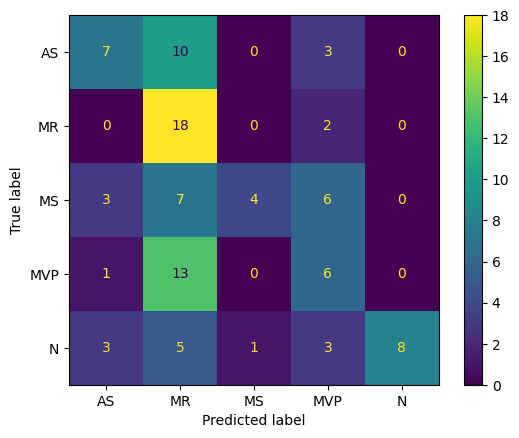

Accuracy : [0.8  0.63 0.83 0.72 0.88] mean:  0.772
Precision : [0.5        0.33962264 0.8        0.3        1.        ] mean:  0.5879245283018868
Sensitivity : [0.35 0.9  0.2  0.3  0.4 ] mean:  0.43
Specificity : [0.9125 0.5625 0.9875 0.825  1.    ] mean:  0.8575000000000002
f1_score: [0.41176471 0.49315068 0.32       0.3        0.57142857] mean:  0.41926879244848625



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb8L10.csv_2.h5
4/4 [==============================] - 0s 2ms/step


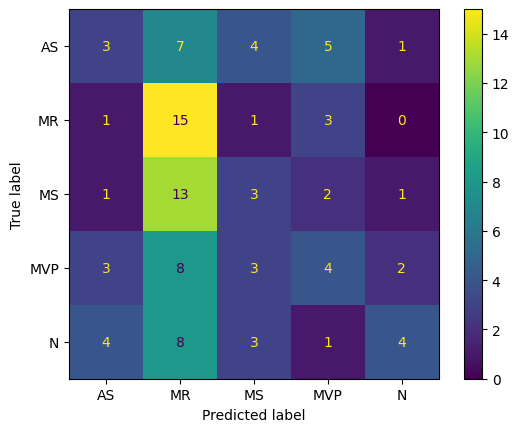

Accuracy : [0.74 0.59 0.72 0.73 0.8 ] mean:  0.716
Precision : [0.25       0.29411765 0.21428571 0.26666667 0.5       ] mean:  0.3050140056022409
Sensitivity : [0.15 0.75 0.15 0.2  0.2 ] mean:  0.29
Specificity : [0.8875 0.55   0.8625 0.8625 0.95  ] mean:  0.8225
f1_score: [0.1875     0.42253521 0.17647059 0.22857143 0.28571429] mean:  0.26015830275772284



Accuracy All : [0.8360000000000001, 0.8240000000000001, 0.908, 0.9280000000000002, 0.9199999999999999, 0.96, 0.9280000000000002, 0.784, 0.772, 0.716]
Precision All : [0.5963768115942029, 0.5788534123031364, 0.7723395445134575, 0.8487280701754386, 0.8140476190476191, 0.9110606060606059, 0.8291632928475033, 0.510487087283426, 0.5879245283018868, 0.3050140056022409]
Sensitivity All : [0.59, 0.56, 0.77, 0.82, 0.8, 0.9, 0.82, 0.45999999999999996, 0.43, 0.29]
Specificity All : [0.8975, 0.89, 0.9425000000000001, 0.9550000000000001, 0.95, 0.975, 0.9550000000000001, 0.8649999999999999, 0.8575000000000002, 0.8225]
f1_score All : [0.577455055

In [14]:
testingVHD(a8, 8)

Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb9L1.csv_5.h5
4/4 [==============================] - 0s 2ms/step


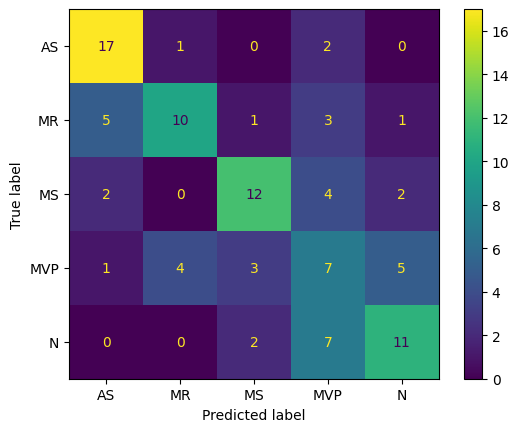

Accuracy : [0.89 0.85 0.86 0.71 0.83] mean:  0.828
Precision : [0.68       0.66666667 0.66666667 0.30434783 0.57894737] mean:  0.5793257055682685
Sensitivity : [0.85 0.5  0.6  0.35 0.55] mean:  0.5700000000000001
Specificity : [0.9    0.9375 0.925  0.8    0.9   ] mean:  0.8925000000000001
f1_score: [0.75555556 0.57142857 0.63157895 0.3255814  0.56410256] mean:  0.5696494067607899



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb9L2.csv_4.h5
4/4 [==============================] - 0s 2ms/step


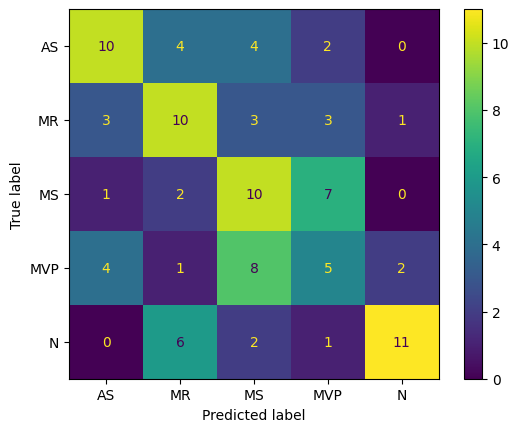

Accuracy : [0.82 0.77 0.73 0.72 0.88] mean:  0.784
Precision : [0.55555556 0.43478261 0.37037037 0.27777778 0.78571429] mean:  0.4848401196227282
Sensitivity : [0.5  0.5  0.5  0.25 0.55] mean:  0.45999999999999996
Specificity : [0.9    0.8375 0.7875 0.8375 0.9625] mean:  0.865
f1_score: [0.52631579 0.46511628 0.42553191 0.26315789 0.64705882] mean:  0.4654361403406645



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb9L3.csv_5.h5
4/4 [==============================] - 0s 2ms/step


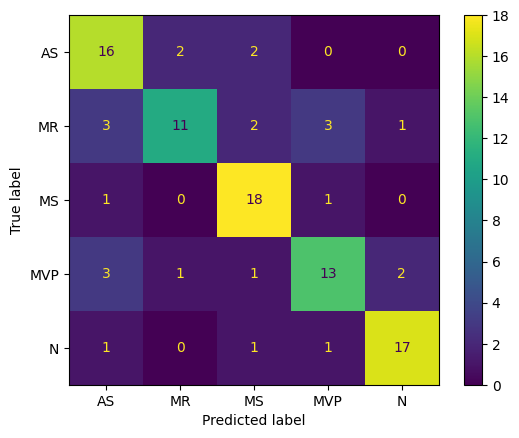

Accuracy : [0.88 0.88 0.92 0.88 0.94] mean:  0.9
Precision : [0.66666667 0.78571429 0.75       0.72222222 0.85      ] mean:  0.754920634920635
Sensitivity : [0.8  0.55 0.9  0.65 0.85] mean:  0.75
Specificity : [0.9    0.9625 0.925  0.9375 0.9625] mean:  0.9375
f1_score: [0.72727273 0.64705882 0.81818182 0.68421053 0.85      ] mean:  0.7453447790599493



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb9L4.csv_5.h5
4/4 [==============================] - 0s 2ms/step


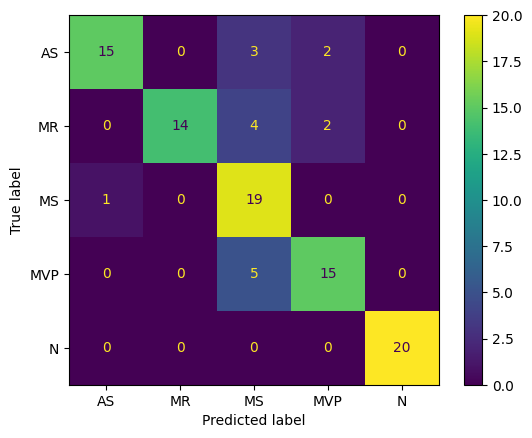

Accuracy : [0.94 0.94 0.87 0.91 1.  ] mean:  0.932
Precision : [0.9375     1.         0.61290323 0.78947368 1.        ] mean:  0.8679753820033955
Sensitivity : [0.75 0.7  0.95 0.75 1.  ] mean:  0.8300000000000001
Specificity : [0.9875 1.     0.85   0.95   1.    ] mean:  0.9574999999999999
f1_score: [0.83333333 0.82352941 0.74509804 0.76923077 1.        ] mean:  0.8342383107088989



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb9L5.csv_3.h5
4/4 [==============================] - 0s 2ms/step


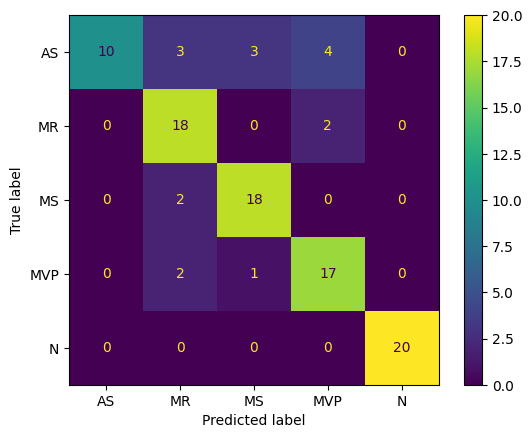

Accuracy : [0.9  0.91 0.94 0.91 1.  ] mean:  0.932
Precision : [1.         0.72       0.81818182 0.73913043 1.        ] mean:  0.8554624505928853
Sensitivity : [0.5  0.9  0.9  0.85 1.  ] mean:  0.8300000000000001
Specificity : [1.     0.9125 0.95   0.925  1.    ] mean:  0.9574999999999999
f1_score: [0.66666667 0.8        0.85714286 0.79069767 1.        ] mean:  0.8229014396456258



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb9L6.csv_5.h5
4/4 [==============================] - 0s 2ms/step


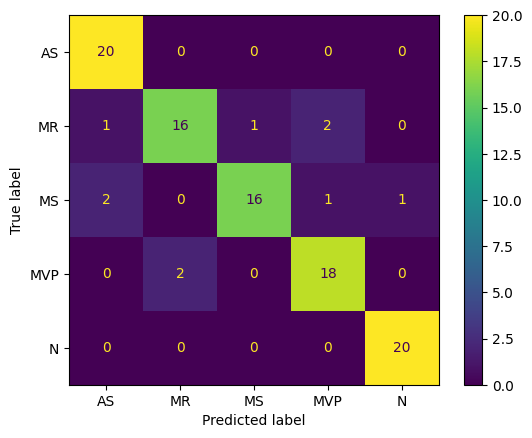

Accuracy : [0.97 0.94 0.95 0.95 0.99] mean:  0.96
Precision : [0.86956522 0.88888889 0.94117647 0.85714286 0.95238095] mean:  0.9018308772784476
Sensitivity : [1.  0.8 0.8 0.9 1. ] mean:  0.9
Specificity : [0.9625 0.975  0.9875 0.9625 0.9875] mean:  0.975
f1_score: [0.93023256 0.84210526 0.86486486 0.87804878 0.97560976] mean:  0.898172244549532



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb9L7.csv_1.h5
4/4 [==============================] - 0s 2ms/step


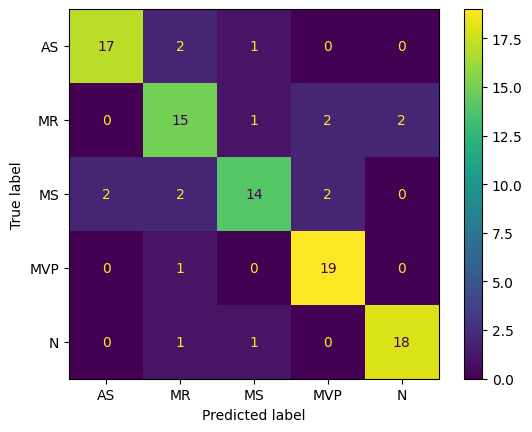

Accuracy : [0.95 0.89 0.91 0.95 0.96] mean:  0.932
Precision : [0.89473684 0.71428571 0.82352941 0.82608696 0.9       ] mean:  0.8317277849354845
Sensitivity : [0.85 0.75 0.7  0.95 0.9 ] mean:  0.8300000000000001
Specificity : [0.975  0.925  0.9625 0.95   0.975 ] mean:  0.9574999999999999
f1_score: [0.87179487 0.73170732 0.75675676 0.88372093 0.9       ] mean:  0.8287959751714714



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb9L8.csv_2.h5
4/4 [==============================] - 0s 2ms/step


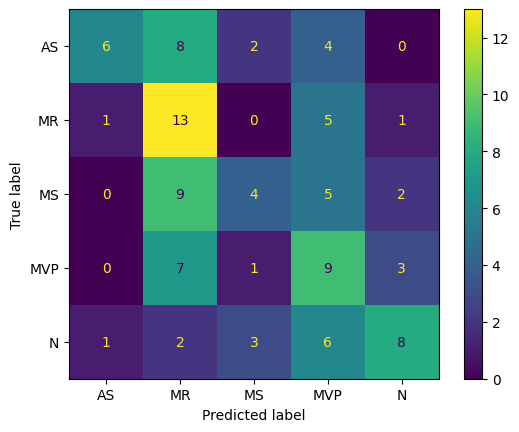

Accuracy : [0.84 0.67 0.78 0.69 0.82] mean:  0.76
Precision : [0.75       0.33333333 0.4        0.31034483 0.57142857] mean:  0.47302134646962235
Sensitivity : [0.3  0.65 0.2  0.45 0.4 ] mean:  0.4
Specificity : [0.975 0.675 0.925 0.75  0.925] mean:  0.85
f1_score: [0.42857143 0.44067797 0.26666667 0.36734694 0.47058824] mean:  0.3947702470818836



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb9L9.csv_2.h5
4/4 [==============================] - 0s 2ms/step


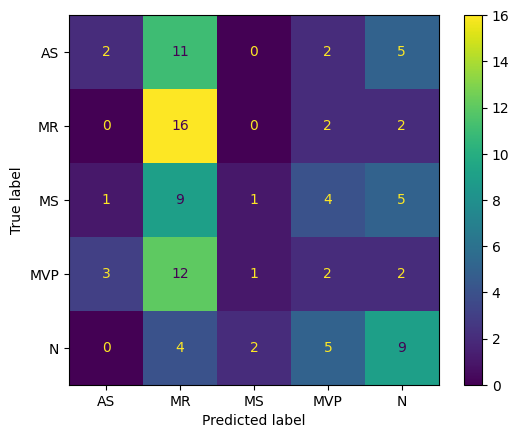

Accuracy : [0.78 0.6  0.78 0.69 0.75] mean:  0.72
Precision : [0.33333333 0.30769231 0.25       0.13333333 0.39130435] mean:  0.28313266443701224
Sensitivity : [0.1  0.8  0.05 0.1  0.45] mean:  0.3
Specificity : [0.95   0.55   0.9625 0.8375 0.825 ] mean:  0.825
f1_score: [0.15384615 0.44444444 0.08333333 0.11428571 0.41860465] mean:  0.24290285941448736



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb9L10.csv_5.h5
4/4 [==============================] - 0s 2ms/step


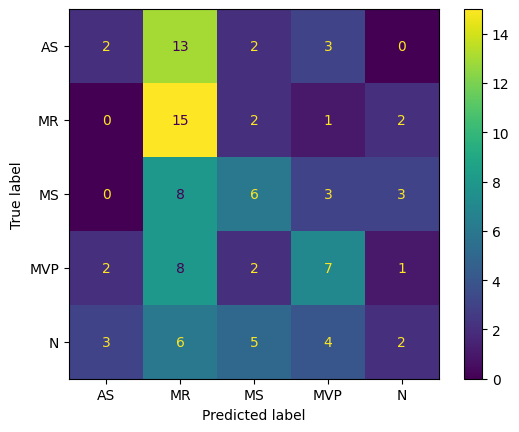

Accuracy : [0.77 0.6  0.75 0.76 0.76] mean:  0.728
Precision : [0.28571429 0.3        0.35294118 0.38888889 0.25      ] mean:  0.31550887021475255
Sensitivity : [0.1  0.75 0.3  0.35 0.1 ] mean:  0.32
Specificity : [0.9375 0.5625 0.8625 0.8625 0.925 ] mean:  0.8299999999999998
f1_score: [0.14814815 0.42857143 0.32432432 0.36842105 0.14285714] mean:  0.2824644193065245



Accuracy All : [0.828, 0.784, 0.9, 0.932, 0.932, 0.96, 0.932, 0.76, 0.72, 0.728]
Precision All : [0.5793257055682685, 0.4848401196227282, 0.754920634920635, 0.8679753820033955, 0.8554624505928853, 0.9018308772784476, 0.8317277849354845, 0.47302134646962235, 0.28313266443701224, 0.31550887021475255]
Sensitivity All : [0.5700000000000001, 0.45999999999999996, 0.75, 0.8300000000000001, 0.8300000000000001, 0.9, 0.8300000000000001, 0.4, 0.3, 0.32]
Specificity All : [0.8925000000000001, 0.865, 0.9375, 0.9574999999999999, 0.9574999999999999, 0.975, 0.9574999999999999, 0.85, 0.825, 0.8299999999999998]
f1_score All : [0.56964940

In [15]:
testingVHD(a9, 9)

Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb10L1.csv_2.h5


4/4 [==============================] - 0s 2ms/step


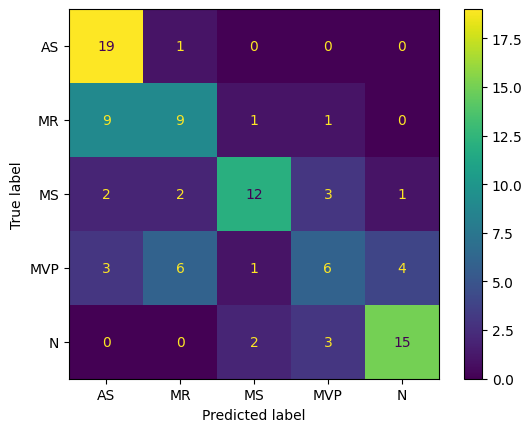

Accuracy : [0.85 0.8  0.88 0.79 0.9 ] mean:  0.844
Precision : [0.57575758 0.5        0.75       0.46153846 0.75      ] mean:  0.6074592074592075
Sensitivity : [0.95 0.45 0.6  0.3  0.75] mean:  0.61
Specificity : [0.825  0.8875 0.95   0.9125 0.9375] mean:  0.9024999999999999
f1_score: [0.71698113 0.47368421 0.66666667 0.36363636 0.75      ] mean:  0.5941936745809635



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb10L2.csv_3.h5
4/4 [==============================] - 0s 2ms/step


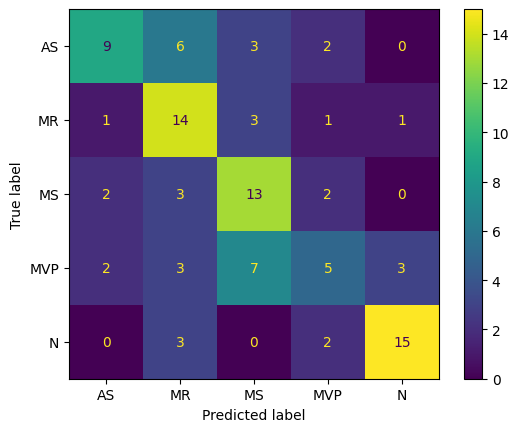

Accuracy : [0.84 0.79 0.8  0.78 0.91] mean:  0.8240000000000001
Precision : [0.64285714 0.48275862 0.5        0.41666667 0.78947368] mean:  0.5663512228847981
Sensitivity : [0.45 0.7  0.65 0.25 0.75] mean:  0.5599999999999999
Specificity : [0.9375 0.8125 0.8375 0.9125 0.95  ] mean:  0.89
f1_score: [0.52941176 0.57142857 0.56521739 0.3125     0.76923077] mean:  0.5495576993339142



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb10L3.csv_5.h5
4/4 [==============================] - 0s 2ms/step


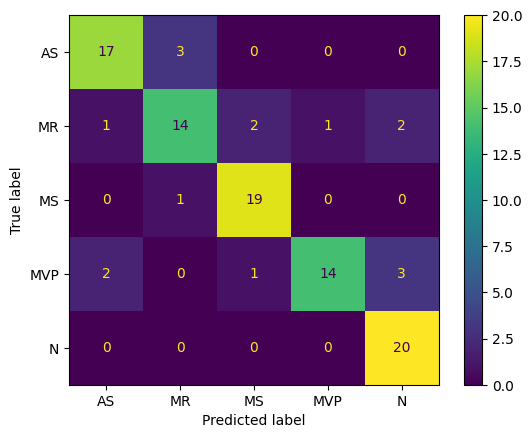

Accuracy : [0.94 0.9  0.96 0.93 0.95] mean:  0.9359999999999999
Precision : [0.85       0.77777778 0.86363636 0.93333333 0.8       ] mean:  0.844949494949495
Sensitivity : [0.85 0.7  0.95 0.7  1.  ] mean:  0.8400000000000001
Specificity : [0.9625 0.95   0.9625 0.9875 0.9375] mean:  0.96
f1_score: [0.85       0.73684211 0.9047619  0.8        0.88888889] mean:  0.8360985797827902



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb10L4.csv_5.h5
4/4 [==============================] - 0s 2ms/step


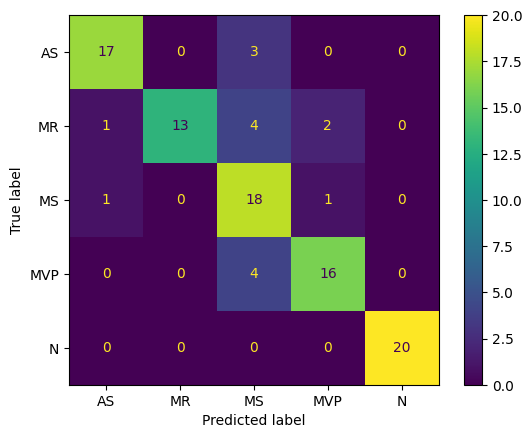

Accuracy : [0.95 0.93 0.87 0.93 1.  ] mean:  0.9359999999999999
Precision : [0.89473684 1.         0.62068966 0.84210526 1.        ] mean:  0.8715063520871145
Sensitivity : [0.85 0.65 0.9  0.8  1.  ] mean:  0.8400000000000001
Specificity : [0.975  1.     0.8625 0.9625 1.    ] mean:  0.9600000000000002
f1_score: [0.87179487 0.78787879 0.73469388 0.82051282 1.        ] mean:  0.8429760715475002



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb10L5.csv_5.h5
4/4 [==============================] - 0s 2ms/step


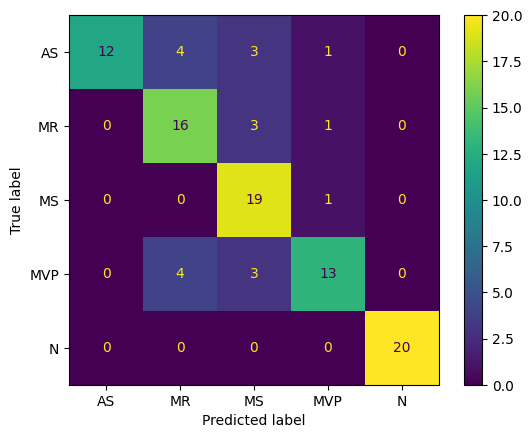

Accuracy : [0.92 0.88 0.9  0.9  1.  ] mean:  0.9199999999999999
Precision : [1.         0.66666667 0.67857143 0.8125     1.        ] mean:  0.831547619047619
Sensitivity : [0.6  0.8  0.95 0.65 1.  ] mean:  0.7999999999999999
Specificity : [1.     0.9    0.8875 0.9625 1.    ] mean:  0.95
f1_score: [0.75       0.72727273 0.79166667 0.72222222 1.        ] mean:  0.7982323232323232



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb10L6.csv_2.h5
4/4 [==============================] - 0s 2ms/step


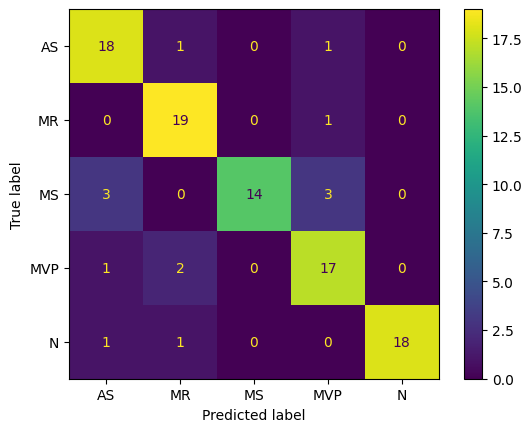

Accuracy : [0.93 0.95 0.94 0.92 0.98] mean:  0.944
Precision : [0.7826087  0.82608696 1.         0.77272727 1.        ] mean:  0.8762845849802371
Sensitivity : [0.9  0.95 0.7  0.85 0.9 ] mean:  0.86
Specificity : [0.9375 0.95   1.     0.9375 1.    ] mean:  0.9650000000000001
f1_score: [0.8372093  0.88372093 0.82352941 0.80952381 0.94736842] mean:  0.8602703749798574



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb10L7.csv_2.h5
4/4 [==============================] - 0s 2ms/step


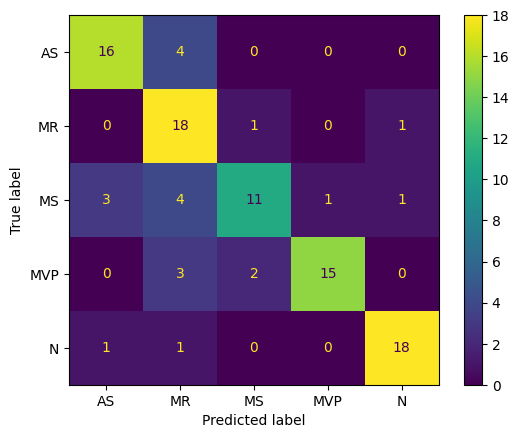

Accuracy : [0.92 0.86 0.88 0.94 0.96] mean:  0.9120000000000001
Precision : [0.8        0.6        0.78571429 0.9375     0.9       ] mean:  0.8046428571428571
Sensitivity : [0.8  0.9  0.55 0.75 0.9 ] mean:  0.78
Specificity : [0.95   0.85   0.9625 0.9875 0.975 ] mean:  0.945
f1_score: [0.8        0.72       0.64705882 0.83333333 0.9       ] mean:  0.7800784313725491



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb10L8.csv_4.h5
4/4 [==============================] - 0s 2ms/step


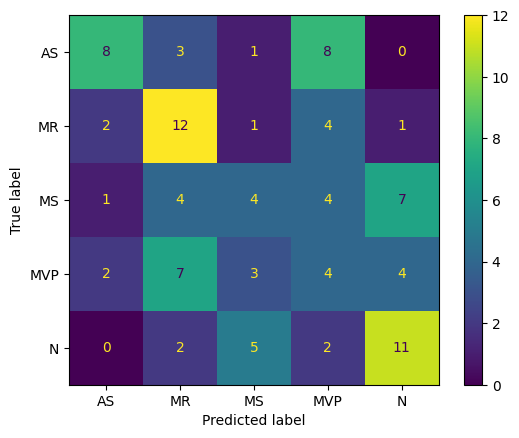

Accuracy : [0.83 0.76 0.74 0.66 0.79] mean:  0.756
Precision : [0.61538462 0.42857143 0.28571429 0.18181818 0.47826087] mean:  0.39794987621074585
Sensitivity : [0.4  0.6  0.2  0.2  0.55] mean:  0.39
Specificity : [0.9375 0.8    0.875  0.775  0.85  ] mean:  0.8474999999999999
f1_score: [0.48484848 0.5        0.23529412 0.19047619 0.51162791] mean:  0.38444933998969566



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb10L9.csv_4.h5
4/4 [==============================] - 0s 2ms/step


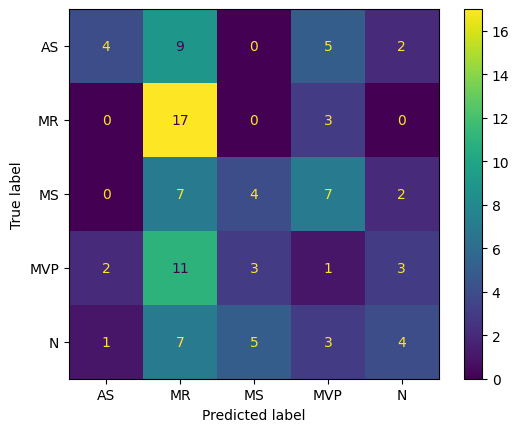

Accuracy : [0.81 0.63 0.76 0.63 0.77] mean:  0.72
Precision : [0.57142857 0.33333333 0.33333333 0.05263158 0.36363636] mean:  0.330872636135794
Sensitivity : [0.2  0.85 0.2  0.05 0.2 ] mean:  0.3
Specificity : [0.9625 0.575  0.9    0.775  0.9125] mean:  0.825
f1_score: [0.2962963  0.47887324 0.25       0.05128205 0.25806452] mean:  0.2669032206287999



Processing ../modelh5/CNN_FT/best_model/CNN_FT_KFold_data_MfccDwtChromaCqtdb10L10.csv_2.h5
4/4 [==============================] - 0s 2ms/step


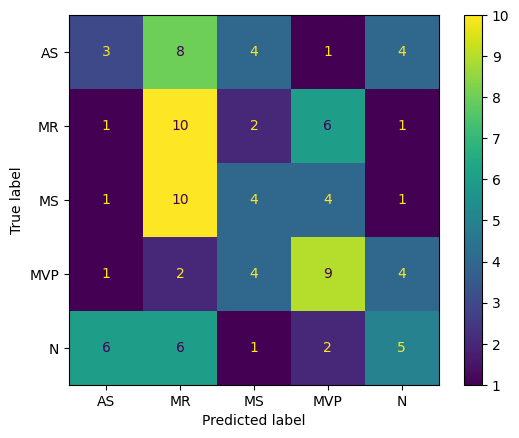

Accuracy : [0.74 0.64 0.73 0.76 0.75] mean:  0.724
Precision : [0.25       0.27777778 0.26666667 0.40909091 0.33333333] mean:  0.3073737373737374
Sensitivity : [0.15 0.5  0.2  0.45 0.25] mean:  0.31
Specificity : [0.8875 0.675  0.8625 0.8375 0.875 ] mean:  0.8274999999999999
f1_score: [0.1875     0.35714286 0.22857143 0.42857143 0.28571429] mean:  0.2975



Accuracy All : [0.844, 0.8240000000000001, 0.9359999999999999, 0.9359999999999999, 0.9199999999999999, 0.944, 0.9120000000000001, 0.756, 0.72, 0.724]
Precision All : [0.6074592074592075, 0.5663512228847981, 0.844949494949495, 0.8715063520871145, 0.831547619047619, 0.8762845849802371, 0.8046428571428571, 0.39794987621074585, 0.330872636135794, 0.3073737373737374]
Sensitivity All : [0.61, 0.5599999999999999, 0.8400000000000001, 0.8400000000000001, 0.7999999999999999, 0.86, 0.78, 0.39, 0.3, 0.31]
Specificity All : [0.9024999999999999, 0.89, 0.96, 0.9600000000000002, 0.95, 0.9650000000000001, 0.945, 0.8474999999999999, 0.825, 0.82749999

In [16]:
testingVHD(a10, 10)